# Демонстрация построения модели на данных с тайм-срезами
# !!!Выборка с данными для запуска скрипта не предоставляется

## 1. Загрузка библиотек и выборок

In [1]:
import pandas as pd
import numpy as np
from vtb_scorekit.data import DataSamples
from vtb_scorekit.woe import WOE
from vtb_scorekit.model import LogisticRegressionModel

result_folder = 'FO_output'
### для запуска скрипта необходимо использовать свою выборку 
df = ...
features = ...
###

for f in features:
    df[f] = pd.to_numeric(df[f])
# Замена бесконечностей и ошибок ФО на уникальные значения
special_bins = {'infinity': 999999999,  # словарь для выделения специальных значений в отдельные бины
                'errors': 9999999999}
for f in features:
    df.loc[df[f].isin([np.inf, -np.inf]), f] = special_bins['infinity']
df.loc[(df['fo_hit'] == 0) & (df['any_fo_hit'] == 1), features] = special_bins['errors']

# Т.к. срезов слишком много, то укрупняем их до годовых
df['year'] = df['report_date'].astype('str').str[:4]

## 2. Создание объекта DataSamples, содержащего все необходимые сэмплы и информацию о них
Выборка уже разбита на сэмплы по полю sample_type_fo

In [2]:
ds = DataSamples(samples={'train': df[df['sample_type_fo'] == 'train'],        # выборка для разработки. Задается в виде словаря {название_сэмпла: датафрейм}, может содержать любое кол-во сэмплов
                          'test': df[df['sample_type_fo'] == 'test'],
                          'other': df[df['sample_type_fo'].isin(['train.other', 'test.other'])]},             
                 target='default1y',                                           # целевая переменная
                 features=features,                                            # список переменных. При None берутся все поля числового типа и нечисловые (кроме target, time_column, id_column) с кол-вом уникльных значений меньше min_nunique
                 id_column='inn',                                              # уникальный в рамках среза айди наблюдения
                 time_column='year',                                           # дата среза
                 feature_descriptions=pd.read_excel('data/FO_description.xlsx', index_col=0), # датафрейм с описанием переменных. Должен содержать индекс с названием переменных и любое кол-во полей с описанием, которые будут подтягиваться в отчеты
                 special_bins=special_bins,                                    # словарь вида {название бина:значение}, каждое из значений которого помещается в отдельный бин
                 result_folder=result_folder,                                  # папка, в которую будут сохраняться все результаты работы с этим ДатаСэмплом
                 min_nunique=20,                                               # кол-во уникальных значений, до которого переменная считается категориальной при автоматическом определении
                 cat_columns=None,                                             # список категориальных переменных. При None категориальными считаются все переменные с кол-вом уникальных значений меньше min_nunique
                 train_name=None,                                              # название сэмпла обучающей выборки. При None берется первый сэмпл
                 n_jobs=24,                                                    # кол-во используемых рабочих процессов, при -1 берется число, равное CPU_LIMIT
                 random_state=0,                                               # сид для генератора случайных чисел, используется во всех остальных методах, где необходимо
                 samples_split=None,                                           # словарь с параметрами для вызова метода self.samples_split
                 bootstrap_split={'df': df[df['sample_type_fo'].isin(['train', 'test', 'train.other', 'test.other'])]}, # словарь с параметрами для вызова метода self.bootstrap_split
                 verbose=True,                                                 # флаг вывода комментариев в процессе создания ДатаСэмпла
                 logger=20                                                     # либо объект logging.Logger, либо числовое значение уровня логгирования:
                                                                               #      10 - выводятся все сообщения с типами debug, info, warning, error
                                                                               #      20 - выводятся все сообщения с типами info, warning, error
                                                                               #      30 - выводятся все сообщения с типами warning, error
                                                                               #      40 - выводятся сообщения только с типом error
                                                                               #      50 - не выводятся никакие сообщения
                 )

[INFO] [2023-04-28 09:41:36] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-04-28 09:41:36] Selected 1 categorical features: ['qn70_bal_liq_assessm']
[INFO] [2023-04-28 09:42:04] 100 bootstrap samples with 130033 observation each and 0.0274 mean target rate were created
[INFO] [2023-04-28 09:42:04] DataSamples stats:
                   train         test        other Bootstrap base
amount             29787        16227        84019         130033
target             797.0        433.0       2331.0         3561.0
target_rate        0.027        0.027        0.028          0.027
period       2014 - 2019  2014 - 2019  2014 - 2019    2014 - 2019


## 3. Автологрег

Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
[INFO] [2023-04-28 09:42:05] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-04-28 09:42:05] Performing autobinning with parameters space of size 1...
[INFO] [2023-04-28 09:42:05] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.2, 'G_gini_increase_restrict': True, 'G_with_test': False, 'WOEO_on': False, 'WOEO_dr_threshold': 0.01, 'WOEO_correct_threshold': 0.85, 'WOEO_miss_is_incorrect': True, 'WOEO_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_

100%|██████████| 242/242 [01:03<00:00,  3.82it/s]


[INFO] [2023-04-28 09:43:13] Scorecard saved to the file FO_auto_dev/auto_fit_scorecard.xlsx
[INFO] [2023-04-28 09:43:13] All done! 242/242 features successfully binned.
[INFO] [2023-04-28 09:43:13] Transforming features...
[INFO] [2023-04-28 09:43:17] ------------------------------------------------------------------------ MFA -------------------------------------------------------------------------
[INFO] [2023-04-28 09:52:19] ---------------------------------------------- Step 1 ----------------------------------------------
[INFO] [2023-04-28 09:52:19] Dropped features with gini lower 10: ['qn8_capproductivity_v2_WOE', 'qn77_fix_asset_to_ass_WOE', 'qn74_int_asset_share_WOE', 'qn69_fin_cycle_p_WOE', 'qn62_gr_prof_to_man_exp_WOE', 'qn5_cur_as_to_as1_WOE', 'qn55_q117a_debt_l_dyn_WOE', 'qn54_q118a_net_debt_l_dyn_WOE', 'qn52_short_to_long_liab1_WOE', 'f97l_WOE', 'f97_WOE', 'f96l_WOE', 'f96_WOE', 'f95l_WOE', 'f95_WOE', 'f31_WOE', 'f22_WOE', 'f192_WOE', 'f180_WOE', 'f179l_WOE', 'f179_WOE'

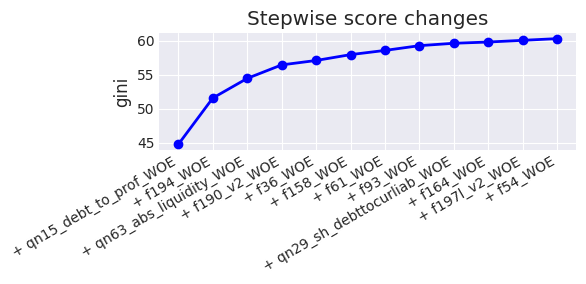

[INFO] [2023-04-28 09:54:45] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-04-28 09:54:45] Dropping features with positive coefs and high p-values...
[INFO] [2023-04-28 09:54:45] To drop: f36_WOE, gini: 10.27, coef: 0.739639299465349
[INFO] [2023-04-28 09:54:46] To drop: f164_WOE, gini: 12.83, coef: 0.5202012310597441
[INFO] [2023-04-28 09:54:46] To drop: qn29_sh_debttocurliab_WOE, gini: 16.14, coef: 0.47205486704666505
[INFO] [2023-04-28 09:54:47] To drop: f197l_v2_WOE, gini: 17.21, p-value: 0.09973507530618654


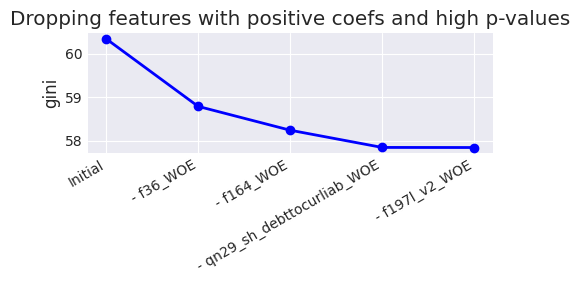

[INFO] [2023-04-28 09:54:47] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-04-28 09:54:47] intercept = -3.658
[INFO] [2023-04-28 09:54:47] coefs = {'qn63_abs_liquidity_WOE': -0.524, 'qn15_debt_to_prof_WOE': -0.475, 'f93_WOE': -0.311, 'f61_WOE': -0.282, 'f54_WOE': -0.21, 'f194_WOE': -0.486, 'f190_v2_WOE': -0.429, 'f158_WOE': -0.407}
[INFO] [2023-04-28 09:54:53] Generating report...


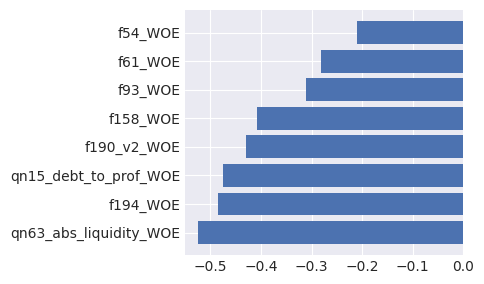

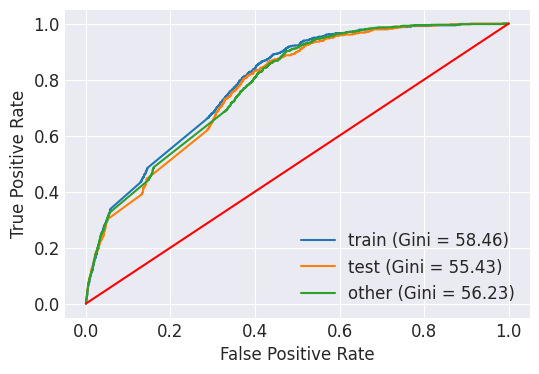

[INFO] [2023-04-28 09:55:50] 
      train   test  other  Bootstrap mean  Bootstrap std
Gini  58.46  55.43  56.23           56.52           0.65


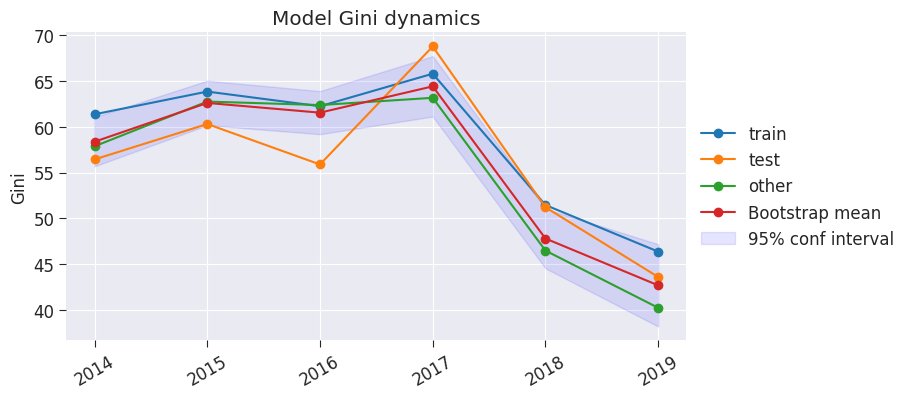

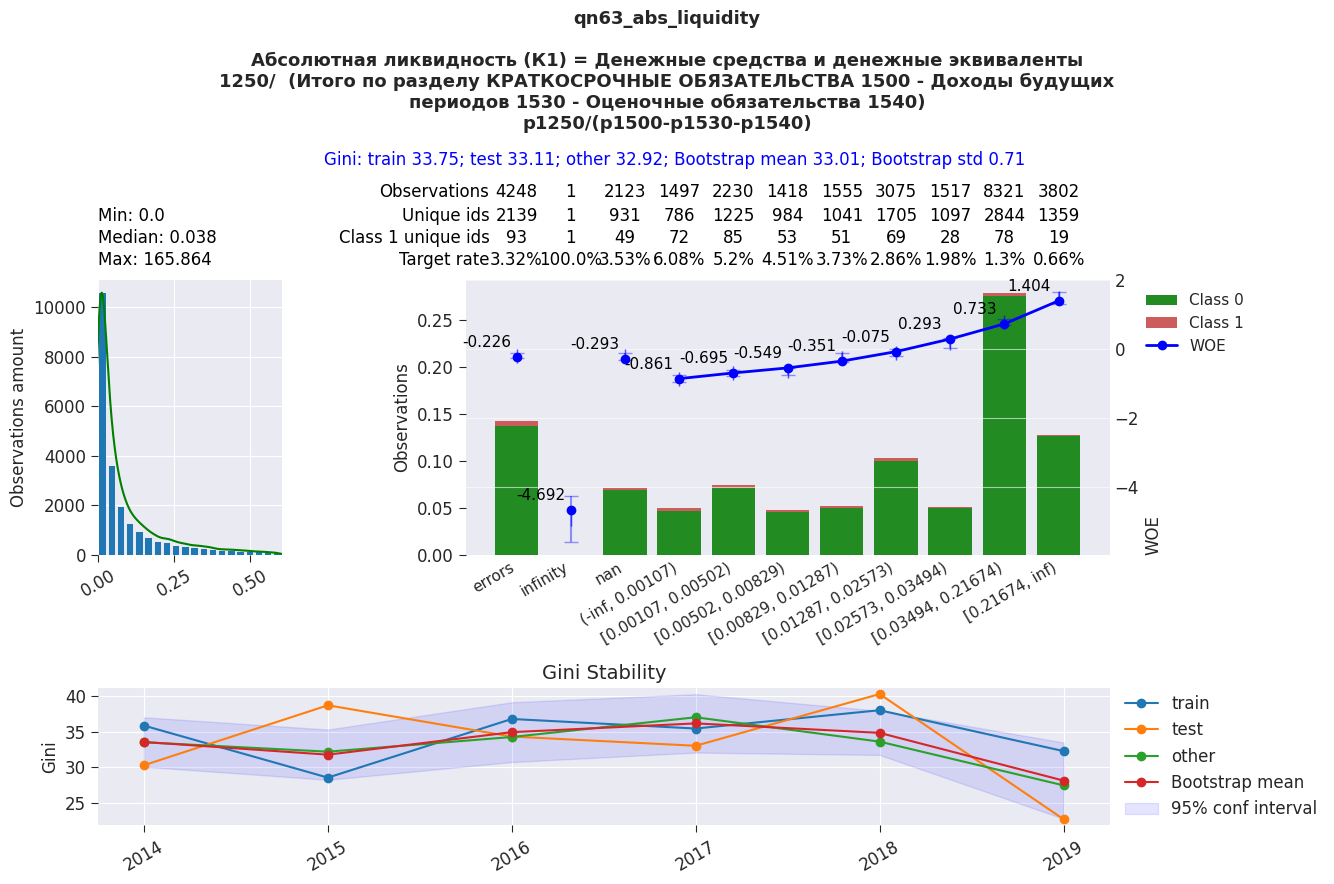

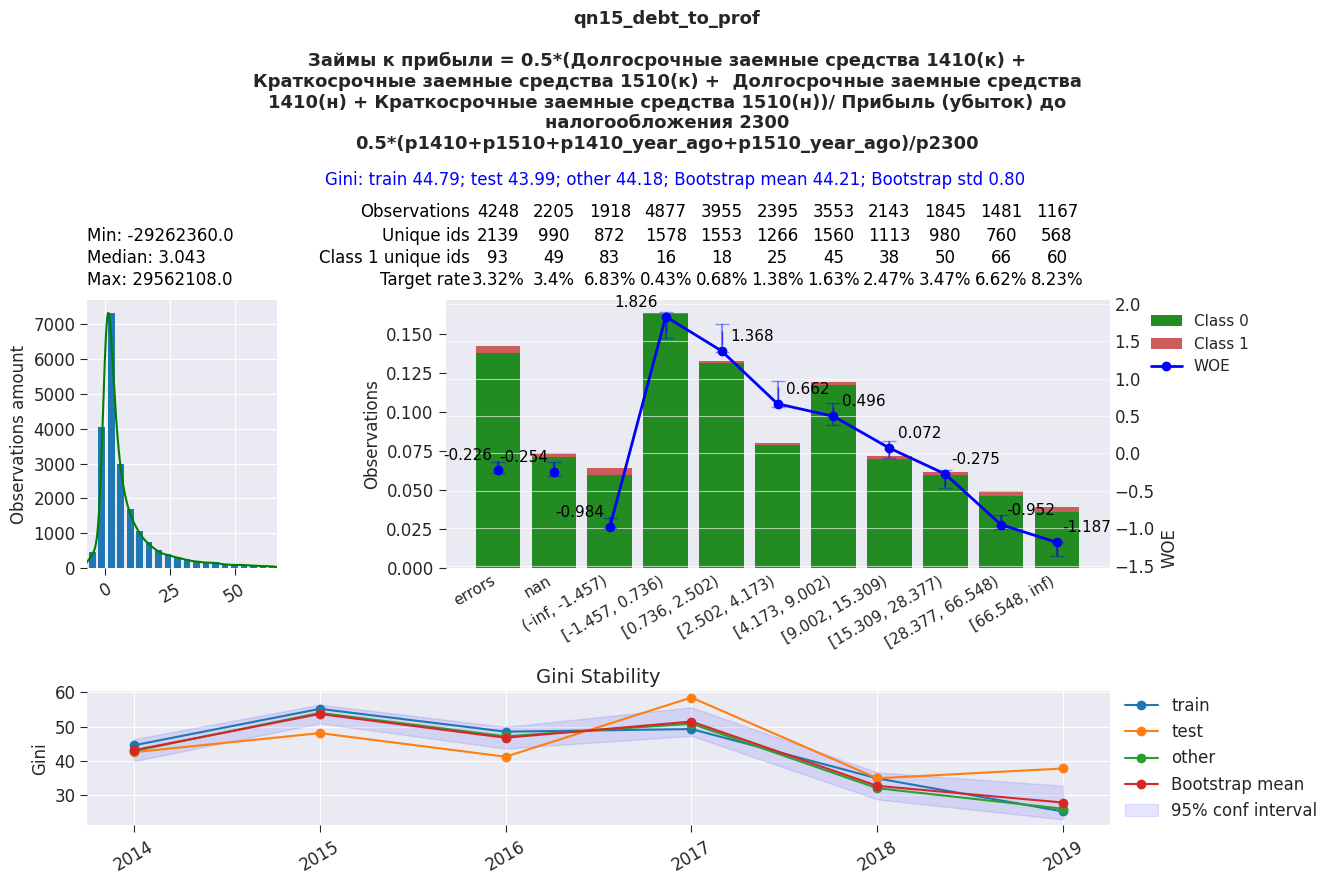

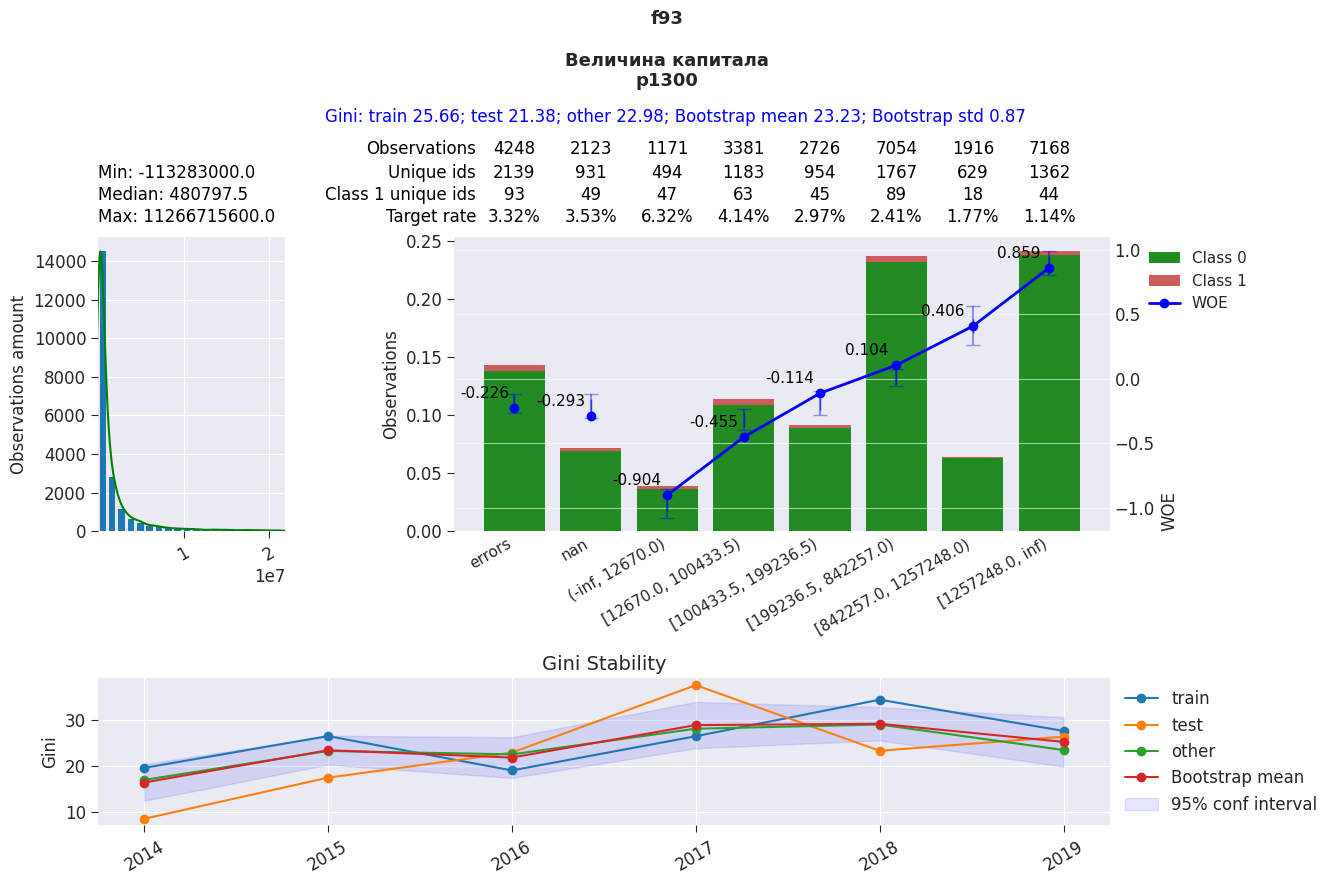

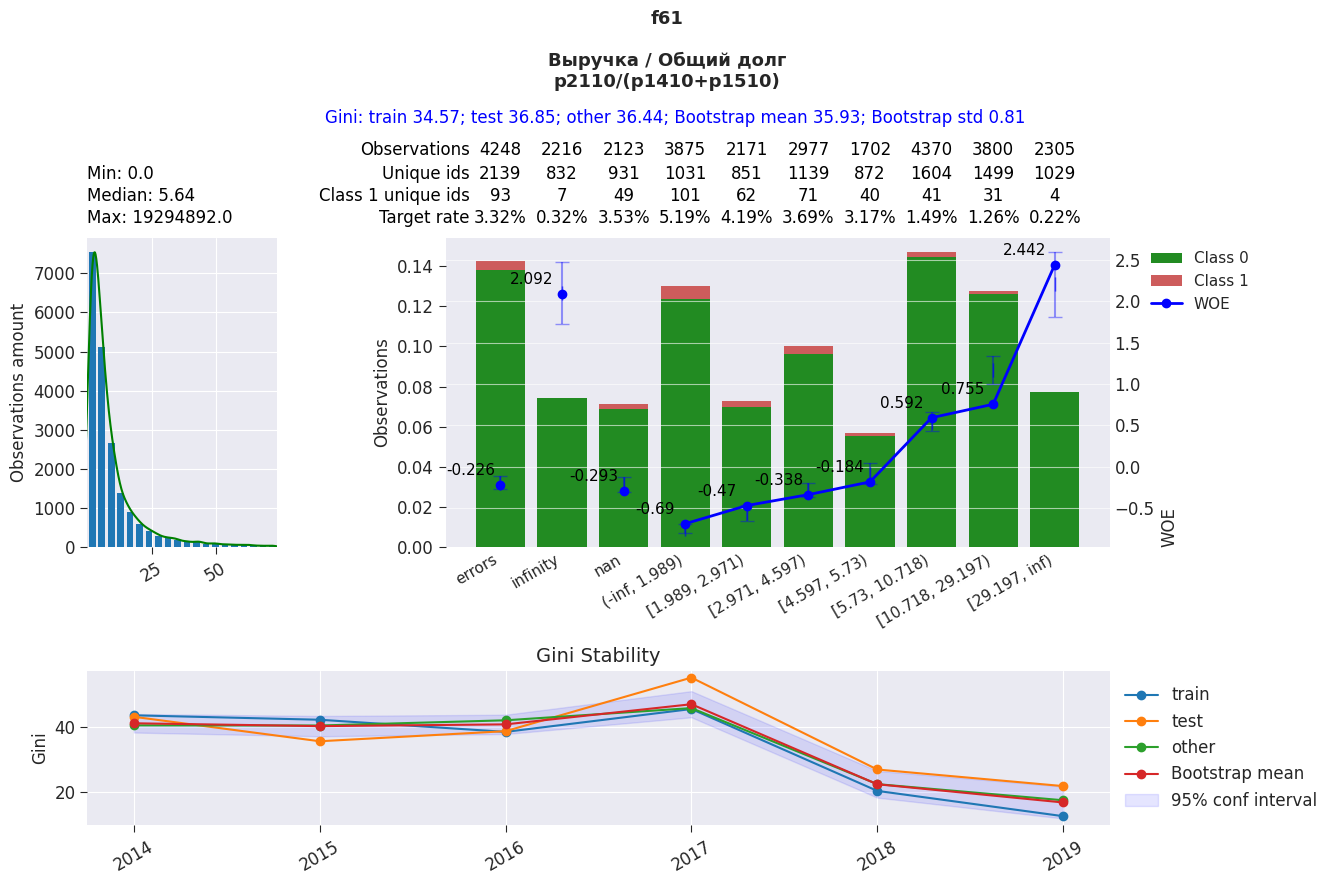

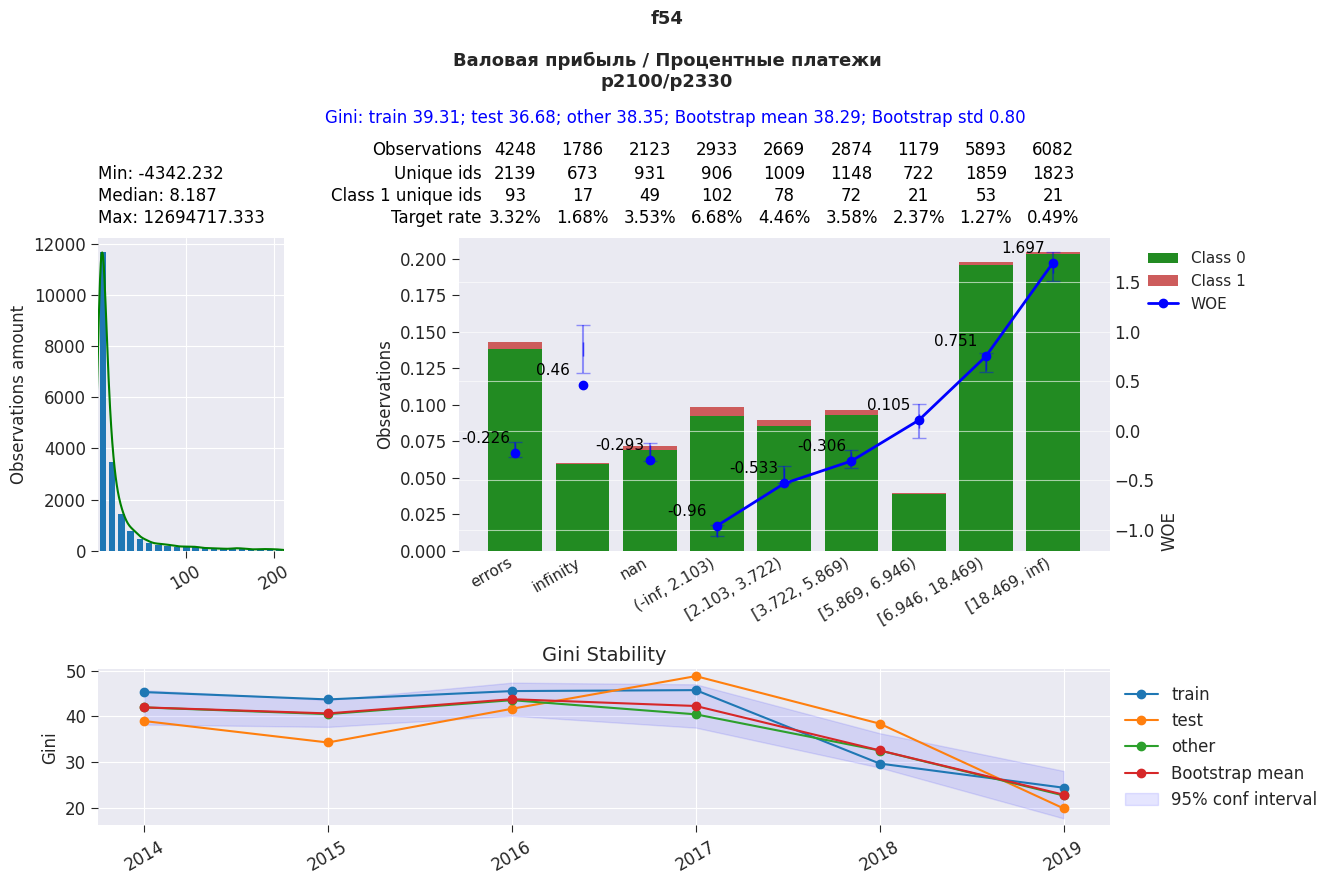

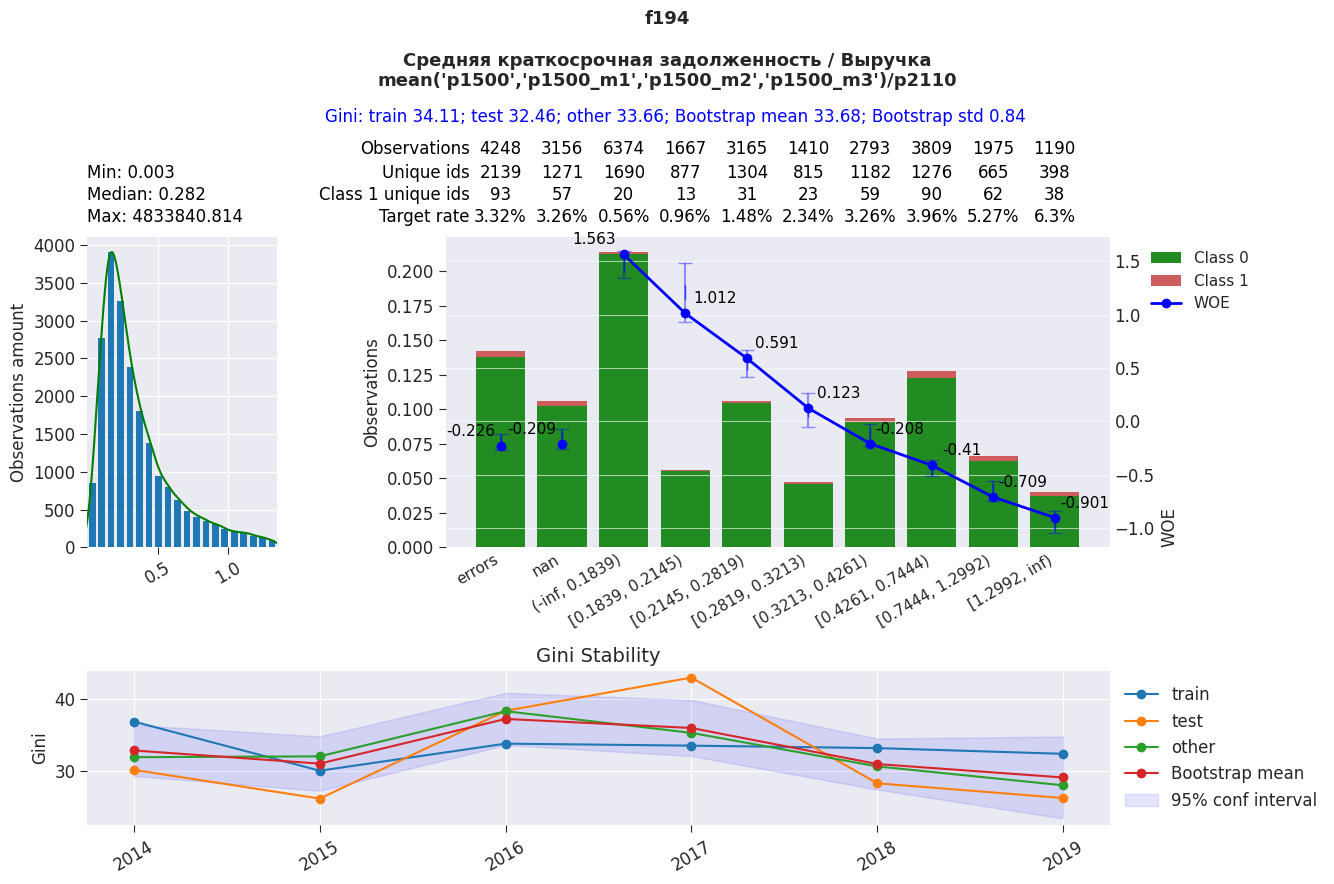

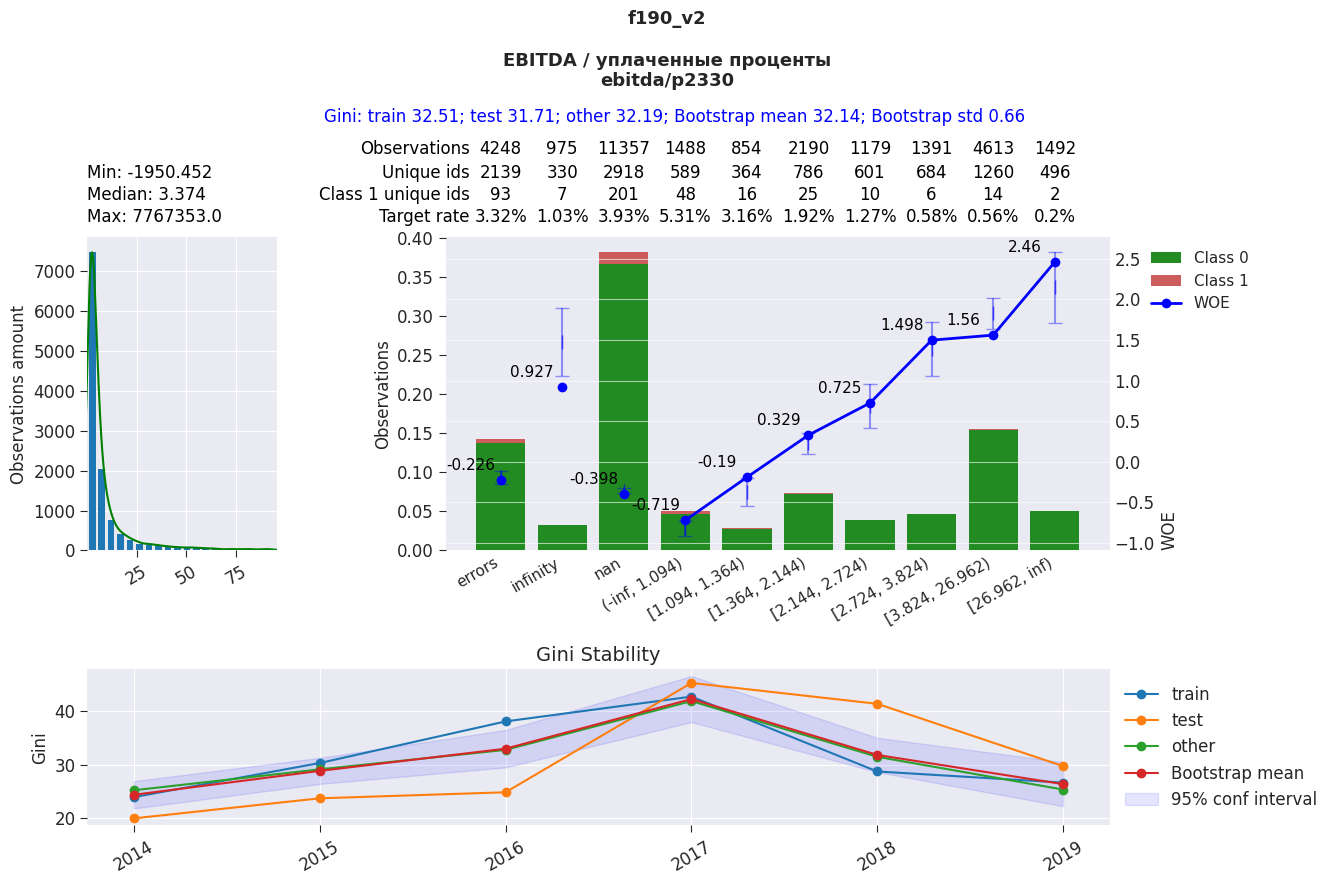

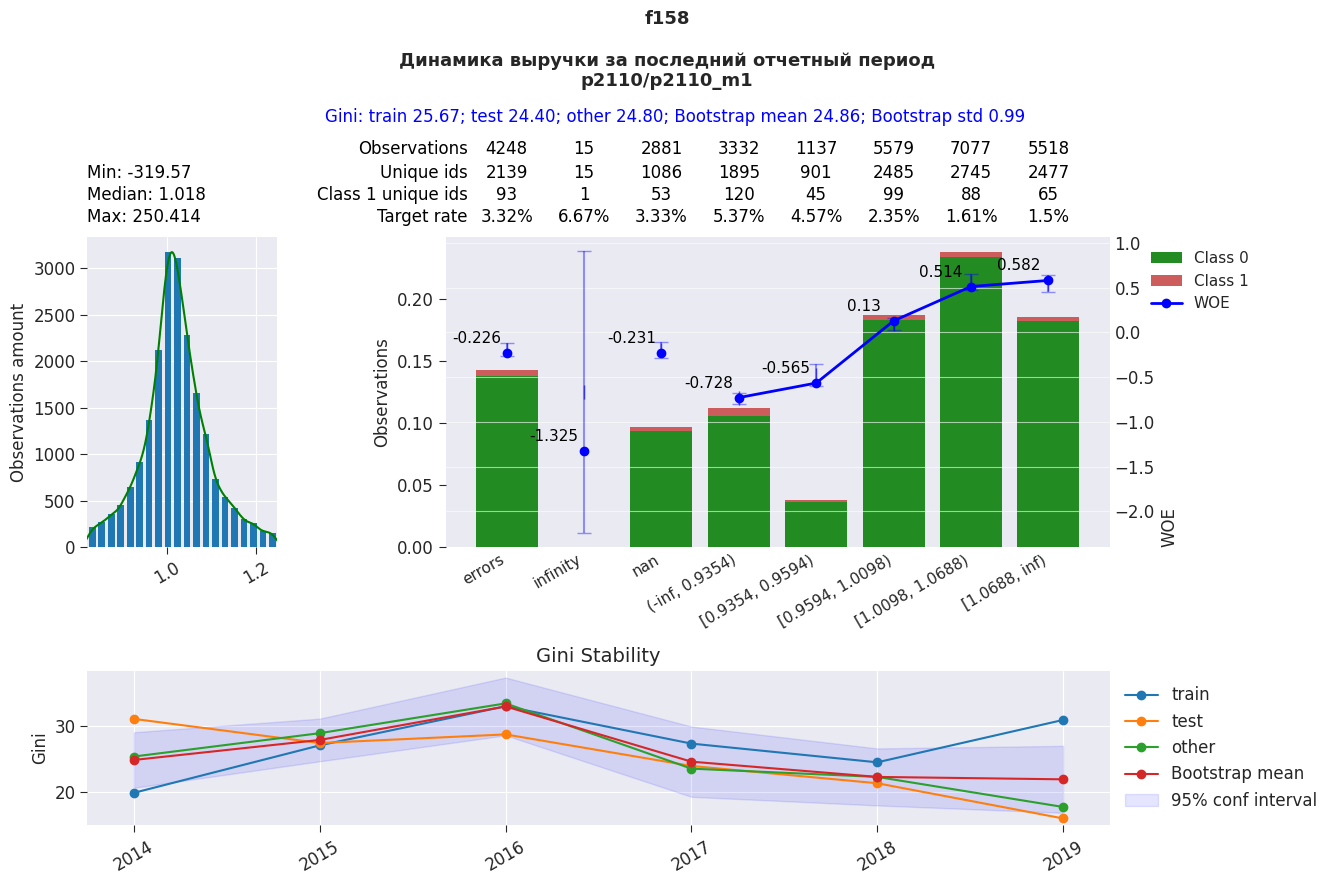

[INFO] [2023-04-28 09:58:13] The model was successfully saved to file FO_auto_dev/auto_model.json
[INFO] [2023-04-28 09:58:13] --------------------------------------------------------------------- Validation ---------------------------------------------------------------------
IV...
Тест Колмогорова-Смирнова...
Джини...
Калибровка...
Корреляция...
VIF...
WOE...
Gini_model...
[INFO] [2023-04-28 09:58:17] Results of validation tests was saved to file FO_auto_dev/auto_validation.xlsx
CPU times: user 13min 18s, sys: 3min 53s, total: 17min 11s
Wall time: 16min 12s


In [3]:
%%time
LogisticRegressionModel().auto_logreg(ds,                            # ДатаФрейм или ДатаСэмпл
                                      result_folder='FO_auto_dev',   # папка, в которую будут сохраняться все результаты работы
                                      validate=True                  # флаг для выполнения валидацонных тестов 
                                     )

## 4. Однофакторный анализ
### 4.1. Создание объекта WOE, содержащего параметры для расчета WOE и биннинги всех переменных
В общем виде WOE в каждом бине i вычисляется по следующей формуле:

$\large {WOE_i = ln\frac{ER \cdot (n + alpha)}{n \cdot ER_i + alpha}}, \\
\
\large {ER = \frac{n_1}{n_0}}, \\
\
\large {ER_i = \frac{n_{1i}+woe\_adjust}{n_{0i}+woe\_adjust}},
$

где $n$ - общее кол-во наблюдений в выборке, 

$n_1$ - общее кол-во наблюдений класса 1, 

$n_0$ - общее кол-во наблюдений класса 0, 

$n_{1i}$ - кол-во наблюдений класса 1 в бине i, 

$n_{0i}$ - кол-во наблюдений класса 0 в бине i, 

$alpha$ и $woe\_adjust$ - коэффициент регуляризации и корректировочная поправка

In [4]:
binning = WOE(ds,                                # ДатаСэмпл, для которого будут рассчитываться биннинги
              features=None,                     # список переменных. При None берется ds.features
              scorecard=None,                    # путь к эксель файлу или датафрейм с готовыми биннингами для импорта
              round_digits=3,                    # округление границ бинов до этого числа знаков после запятой.
                                                 # При округлении происходит проверка на долю мигрирующих наблюдений. Если округление приедет к миграции большой доли наблюдений,
                                                 # то round_digits увеличивается до тех пор, пока доля не упадет ниже rounding_migration_coef
              rounding_migration_coef=0.005,     # максимально допустимая доля наблюдений для миграции между бинами при округлении
              # ---Параметры для расчета WOE---
              simple=True,                       # если True, то расчет WOE происходит на трэйн сэмпле, иначе берется среднее значение по фолдам
              n_folds=5,                         # кол-во фолдов для расчета WOE при simple=False
              woe_adjust=0.5,                    # корректировочный параметр для расчета EventRate_i в бине i                                                
              alpha=0,                           # коэффициент регуляризации для расчета WOE
              alpha_range=None,                  # если alpha=None, то подбирается оптимальное значение alpha из диапазона alpha_range. При None берется диапазон range(10, 100, 10)
              alpha_scoring='neg_log_loss',      # метрика, используемая для оптимизации alpha
              alpha_best_criterion='min',        # 'min' - минимизация метрики alpha_scoring, 'max' - максимизация метрики
              
              # ---Обработка пустых значений---
              missing_process='min_or_separate', # способ обработки пустых значений:
                                                 #     'separate' - помещать в отдельный бин
                                                 #     'min' - объединять с бином с минимальным WOE
                                                 #     'max' - объединять с бином с максимальным WOE
                                                 #     'nearest' - объединять с ближайшим по WOE биномом
                                                 #     'min_or_separate' - если доля пустых значений меньше missing_min_part, то объединять с бином с минимальным WOE, иначе помещать в отдельный бин
                                                 #     'max_or_separate' - если доля пустых значений меньше missing_min_part, то объединять с бином с максимальным WOE, иначе помещать в отдельный бин
                                                 #     'nearest_or_separate' - если доля пустых значений меньше missing_min_part, то объединять с ближайшим по WOE бином, иначе помещать в отдельный бин
              missing_min_part=0.01,             # минимальная доля пустых значений для выделения отдельного бина при missing_process 'min_or_separate', 'max_or_separate' или 'nearest_or_separate'
              
              # ---Обработка остальных значений, не попавших в биннинг---
              others='missing_or_min',           # Способ обработки значений, не попавших в биннинг:
                                                 #     'min': остальным значениям присваивается минимальный WOE
                                                 #     'max': остальным значениям присваивается максимальный WOE
                                                 #     'missing_or_min': если есть бакет с пустыми значениями, то остальным значениям присваивается его WOE, иначе минимальный WOE
                                                 #     'missing_or_max': если есть бакет с пустыми значениями, то остальным значениям присваивается его WOE, иначе максимальный WOE
                                                 #     float: отсутствующим значениям присваивается заданный фиксированный WOE
              opposite_sign_to_others=True,      # В случае, когда непрерывная переменная на выборке для разработки имеет только один знак,
                                                 # то все значения с противоположным знаком относить к others              
             )

### 4.2. Поиск оптимального биннинга
Итерационно для каждой переменной выполняются следующие шаги: <br>
 1) Исходное разбиение на n бинов, где n берется последовательно из списка groups_range <br>
 2) Выполняются слияния соседних бинов с близким WOE (при выставленном флаге WOEM_on=True) и малых бинов (SM_on=True) <br>
 3) Проводятся проверки на джини (G_on=True), порядок (WOEO_on=True) и бизнес-логику (BL_on=True) <br>
 4) Если любая из проверок проваливается, то возвращаемся на шаг 1 и берем следующее значение из groups_range <br>
 
Если после перебора всех n проверки так и не успешны, то переменная исключается из списка. <br>
В случае, если задан params_space, то вся процедура повторяется для каждого набора параметров и затем выбирается биннинг с наибольшим джини.


In [5]:
%%time
binning.auto_fit(features=None,                   # список переменных для обработки. По умолчанию берутся из self.ds.features
                 autofit_folder='auto_fit',       # название папки, в которую будут сохранены результаты автобиннинга
                 plot_flag=False,                 # вывести графики с биннингом
                 verbose=False,                   # флаг для вывода подробных комментариев в процессе работы
                 
                 # --- Метод биннинга ---
                 method='opt',                   # 'tree' - биннинг деревом, 'opt' - биннинг деревом с последующей оптимизацией границ бинов библиотекой optbinning
                 max_n_bins=15,                  # максимальное кол-во бинов
                 min_bin_size=0.05,              # минимальное число (доля) наблюдений в каждом листе дерева.
                                                 #    Если min_bin_size < 1, то трактуется как доля наблюдений от обучающей выборки
                 
                 # --- Параметры биннинга для метода 'tree' ---
                 criterion='entropy',            # критерий расщепления. Варианты значений: 'entropy', 'gini'
                 scoring='neg_log_loss',         # метрика для оптимизации
                 max_depth=5,                    # максимальная глубина дерева
                 
                 #--- Параметры биннинга для метода 'opt' ---
                 solver='cp',                    # солвер для оптимизации биннинга:
                                                 #   'cp' - constrained programming
                                                 #   'mip' - mixed-integer programming
                                                 #   'ls' - LocalSorver (www.localsorver.com)
                 divergence='iv',                # метрика для максимизации:
                                                 #   'iv' - Information Value,
                                                 #   'js' - Jensen-Shannon,
                                                 #   'hellinger' - Hellinger divergence,
                                                 #   'triangular' - triangular discrimination

                 # ---Параметры проверок---
                 WOEM_on=True,                    # флаг проверки на разницу WOE между соседними группами
                 WOEM_woe_threshold=0.1,          # если дельта WOE между соседними группами меньше этого значения, то группы объединяются
                 WOEM_with_missing=False,         # должна ли выполняться проверка для бина с пустыми значениями
                 SM_on=False,                     # проверка на размер бина
                 SM_target_threshold=10,          # минимальное кол-во (доля) наблюдений с целевым событием в бине
                 SM_size_threshold=100,           # минимальное кол-во (доля) наблюдений в бине
                 BL_on=True,                      # флаг проверки на бизнес-логику
                 BL_allow_Vlogic_to_increase_gini=15, # разрешить V-образную бизнес-логику, если она приводит к увеличению джини переменной на эту величину относительного монотонного тренда.
                                                  # При значении 100 V-образная бизнес-логика запрещена
                 G_on=True,                       # флаг проверки на джини
                 G_gini_threshold=10,             # минимальное допустимое джини переменной.
                                                  #    Проверяется на трэйн сэмпле, + если заданы бутстрэп сэмплы, то проверяется условие mean-1.96*std > G_gini_threshold
                 G_with_test=True,                # так же проверять джини на остальных доступных сэмплах
                 G_gini_decrease_threshold=0.3,   # допустимое уменьшение джини на всех сэмплах относительно трэйна.
                                                  # В случае, если значение >= 1, то проверяется условие gini(train) - gini(sample) <= G_gini_decrease_threshold для основных сэмплов
                                                  #                                                    и 1.96*std <= G_gini_decrease_threshold для бутсрэп сэмплов
                                                  # если значение < 1, то проверяется условие 1 - gini(sample)/gini(train) <= G_gini_decrease_threshold для основных сэмплов
                                                  #                    
                 G_gini_increase_restrict=True,   # так же ограничение действует и на увеличение джини
                 WOEO_on=True,                    # флаг проверки на сохранения порядка WOE на бутстрэп-сэмплах
                 WOEO_dr_threshold=0.005,         # допустимая дельта между TargetRate бинов для прохождения проверки, в случае нарушения порядка
                 WOEO_correct_threshold=0.90,     # доля бутстрэп-сэмплов, на которых должна проходить проверка
                 WOEO_miss_is_incorrect=False,    # считать ли отсутствие данных в бине сэмпла ошибкой или нет
                 WOEO_with_test=True,             # так же проверять тренд на остальных доступных сэмплах

                 # ---Пространство параметров---
                 params_space={'method': ['opt',  'tree'],  # пространство параметров, с которыми будут выполнены автобиннинги.
                               'min_bin_size': [0.05, 0.1]},               
                 woe_best_samples=None,           # список сэмплов, по которым будет определяться лучший джини df_gini[woe_best_samples].mean(axis=1). По умолчанию берется джини на трэйне
                                  
                 #--- Кросс переменные ---
                 cross_features_first_level=None,  # список переменных первого уровня для которых будут искаться лучшие кросс пары. При None берется features
                 cross_num_second_level=0          # кол-во кросс пар, рассматриваемых для каждой переменной первого уровня
                                                   #   0 - поиск не производится
                                                   #  -1 - рассматриваются все возможные кросс пары
                                                   #   n - для каждой переменной первого уровня отбираются n лучших переменных с максимальной метрикой criterion
                )


[INFO] [2023-04-28 09:58:17] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-04-28 09:58:17] Performing autobinning with parameters space of size 4...
[INFO] [2023-04-28 09:58:17] Using parameters set 1/4: {'method': 'opt', 'max_n_bins': 15, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.1, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 10, 'SM_size_threshold': 100, 'G_on': True, 'G_gini_threshold': 10, 'G_gini_decrease_threshold': 0.3, 'G_gini_increase_restrict': True, 'G_with_test': True, 'WOEO_on': True, 'WOEO_dr_threshold': 0.005, 'WOEO_correct_threshold': 0.9, 'WOEO_miss_is_incorrect': False, 'WOEO_with_test': True, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 15, 'verbose': False}
[INFO] [2023-04-28 09:58:17] Processing 242

100%|██████████| 242/242 [01:47<00:00,  2.24it/s]


[INFO] [2023-04-28 10:01:41] Using parameters set 2/4: {'method': 'opt', 'max_n_bins': 15, 'min_bin_size': 0.1, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.1, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 10, 'SM_size_threshold': 100, 'G_on': True, 'G_gini_threshold': 10, 'G_gini_decrease_threshold': 0.3, 'G_gini_increase_restrict': True, 'G_with_test': True, 'WOEO_on': True, 'WOEO_dr_threshold': 0.005, 'WOEO_correct_threshold': 0.9, 'WOEO_miss_is_incorrect': False, 'WOEO_with_test': True, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 15, 'verbose': False}
[INFO] [2023-04-28 10:01:41] Processing 242 features on 24 CPUs...


100%|██████████| 242/242 [01:30<00:00,  2.68it/s]


[INFO] [2023-04-28 10:04:23] Using parameters set 3/4: {'method': 'tree', 'max_n_bins': 15, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.1, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 10, 'SM_size_threshold': 100, 'G_on': True, 'G_gini_threshold': 10, 'G_gini_decrease_threshold': 0.3, 'G_gini_increase_restrict': True, 'G_with_test': True, 'WOEO_on': True, 'WOEO_dr_threshold': 0.005, 'WOEO_correct_threshold': 0.9, 'WOEO_miss_is_incorrect': False, 'WOEO_with_test': True, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 15, 'verbose': False}
[INFO] [2023-04-28 10:04:23] Processing 242 features on 24 CPUs...


100%|██████████| 242/242 [01:44<00:00,  2.32it/s]


[INFO] [2023-04-28 10:07:20] Using parameters set 4/4: {'method': 'tree', 'max_n_bins': 15, 'min_bin_size': 0.1, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.1, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 10, 'SM_size_threshold': 100, 'G_on': True, 'G_gini_threshold': 10, 'G_gini_decrease_threshold': 0.3, 'G_gini_increase_restrict': True, 'G_with_test': True, 'WOEO_on': True, 'WOEO_dr_threshold': 0.005, 'WOEO_correct_threshold': 0.9, 'WOEO_miss_is_incorrect': False, 'WOEO_with_test': True, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 15, 'verbose': False}
[INFO] [2023-04-28 10:07:20] Processing 242 features on 24 CPUs...


100%|██████████| 242/242 [01:32<00:00,  2.61it/s]


[INFO] [2023-04-28 10:09:56] Scorecard saved to the file FO_output/auto_fit_scorecard.xlsx
[INFO] [2023-04-28 10:09:56] Plotting binnings...


100%|██████████| 242/242 [02:52<00:00,  1.41it/s]
0it [00:00, ?it/s]


[INFO] [2023-04-28 10:12:55] All done! 242/242 features successfully binned.
CPU times: user 7min 33s, sys: 2min 15s, total: 9min 49s
Wall time: 14min 38s


### 4.3. Загрузка биннинга из скоркарты

In [6]:
binning = WOE(ds, scorecard='FO_output/auto_fit_scorecard.xlsx')

## 5. Многофакторный анализ
### 5.1. Создание объекта класса модели LogisticRegressionModel

In [7]:
logreg = LogisticRegressionModel(clf=None,            # классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_). При None выбирается SGDClassifier(alpha=0.001, loss='log', max_iter=100)
                                 transformer=binning, # объект класса WOE для предварительной трансформации факторов
                                 ds=None,             # Привязанный к модели ДатаСэмпл. Если задан, то он по умолчанию будет использоваться во всех методах
                                 round_digits=3,      # округление коэффициентов до этого кол-ва знаков после запятой   
                                 name='FO',           # название модели
                                )  

Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)


### 5.2. Предварительная трансформация ДатаСэмла (опционально)

In [8]:
ds_t = binning.transform(ds)

### 5.3. Выполнение многофакторного отбора
Проходит в 4 основных этапа:
1) Отбор по джини (исключаются все факторы с джини ниже gini_threshold)
2) Корреляционный анализ. Доступны два варианта работы: <br>
&emsp;&emsp; drop_with_most_correlations=False - итерационно исключается фактор с наименьшим джини из списка коррелирующих факторов<br>
&emsp;&emsp; drop_with'stepwise'_most_correlations=True - итерационно исключается фактор с наибольшим кол-вом коррелирующих с ним факторов
3) Итерационный отобор. Доступны три типа отбора:<br>
&emsp;&emsp; selection_type='forward' - все доступные факторы помещаются в список кандидатов, на каждом шаге из списка кандидатов определяется лучший* фактор и перемещается в модель<br>
&emsp;&emsp; selection_type='backward' - в модель включаются все доступные факторы, затем на каждом шаге исключается худший* фактор<br>
&emsp;&emsp; selection_type='stepwise' - комбинация 'forward' и 'backward'. Каждый шаг состоит из двух этапов:<br>
&emsp;&emsp;&emsp;&emsp; на первом из списка кандидатов отбирается лучший* фактор в модель,<br>
&emsp;&emsp;&emsp;&emsp; на втором из уже включенных факторов выбирается худший* и исключается<br>
           
&emsp;&emsp; *Определение лучшего фактора:<br>
&emsp;&emsp;&emsp;&emsp; При pvalue_priority=False лучшим фактором считается тот, который увеличивает метрику scoring модели на наибольшую величину.<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Если величина такого увеличения ниже score_delta, то лучший фактора не определяется, и добавления не происходит<br>
&emsp;&emsp;&emsp;&emsp; При pvalue_priority=True лучшим фактором считается фактор, который после добавления в модель имеет наименьшее p-value.<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Если величина этого p-value выше pvalue_threshold, то лучший фактора не определяется, и добавления не происходит<br>
        
&emsp;&emsp; *Определение худшего фактора:<br>
&emsp;&emsp;&emsp;&emsp; Худшим фактором в модели считается фактор с наибольшим p-value.<br>
&emsp;&emsp;&emsp;&emsp; Если величина этого p-value ниже pvalue_threshold, то худший фактора не определяется, и исключения не происходит<br>
4) Если выставлен флаг drop_positive_coefs=True, то из списка отобранных на этапе 3 факторов исключаются факторы с положительным коэффициентом

[INFO] [2023-04-28 10:13:03] ------------------------------------------------------------------------ MFA -------------------------------------------------------------------------
[INFO] [2023-04-28 10:22:12] ---------------------------------------------- Step 1 ----------------------------------------------
[INFO] [2023-04-28 10:22:12] Dropped features with gini lower 10: ['qn8_capproductivity_v2_WOE', 'qn77_fix_asset_to_ass_WOE', 'qn74_int_asset_share_WOE', 'qn69_fin_cycle_p_WOE', 'qn62_gr_prof_to_man_exp_WOE', 'qn5_cur_as_to_as1_WOE', 'qn55_q117a_debt_l_dyn_WOE', 'qn54_q118a_net_debt_l_dyn_WOE', 'qn52_short_to_long_liab1_WOE', 'f97l_WOE', 'f97_WOE', 'f96l_WOE', 'f96_WOE', 'f95l_WOE', 'f95_WOE', 'f31_WOE', 'f22_WOE', 'f192_WOE', 'f180_WOE', 'f179l_WOE', 'f179_WOE', 'f178_WOE', 'f177_WOE', 'f176_WOE', 'f175_WOE', 'f174_WOE', 'f173l_WOE', 'f173_WOE', 'f172_WOE', 'f168_WOE', 'f165_WOE', 'f100_WOE']
[INFO] [2023-04-28 10:22:12] ---------------------------------------------- Step 2 ------

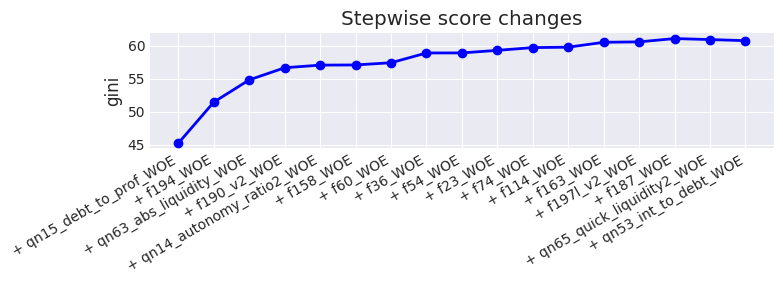

[INFO] [2023-04-28 10:26:02] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-04-28 10:26:02] Dropping features with positive coefs and high p-values...
[INFO] [2023-04-28 10:26:02] To drop: f36_WOE, gini: 10.27, coef: 0.6114473231251573
[INFO] [2023-04-28 10:26:03] To drop: f187_WOE, gini: 12.9, coef: 0.5755254040778072
[INFO] [2023-04-28 10:26:03] To drop: f163_WOE, gini: 13.66, coef: 0.6334843785542525
[INFO] [2023-04-28 10:26:04] To drop: f74_WOE, gini: 23.02, coef: 0.46912637260674334
[INFO] [2023-04-28 10:26:04] To drop: f197l_v2_WOE, gini: 16.64, p-value: 0.24652320229540756
[INFO] [2023-04-28 10:26:05] To drop: qn65_quick_liquidity2_WOE, gini: 27.27, p-value: 0.06613034114450257


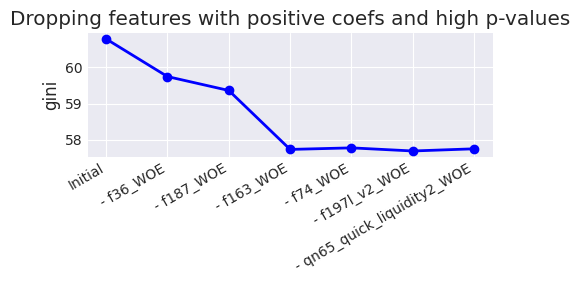

[INFO] [2023-04-28 10:26:06] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-04-28 10:26:06] intercept = -3.684
[INFO] [2023-04-28 10:26:06] coefs = {'qn63_abs_liquidity_WOE': -0.501, 'qn53_int_to_debt_WOE': -0.298, 'qn15_debt_to_prof_WOE': -0.497, 'qn14_autonomy_ratio2_WOE': -0.304, 'f60_WOE': -0.32, 'f54_WOE': -0.157, 'f23_WOE': -0.197, 'f194_WOE': -0.283, 'f190_v2_WOE': -0.378, 'f158_WOE': -0.324, 'f114_WOE': -0.209}
[INFO] [2023-04-28 10:26:12] Generating report...


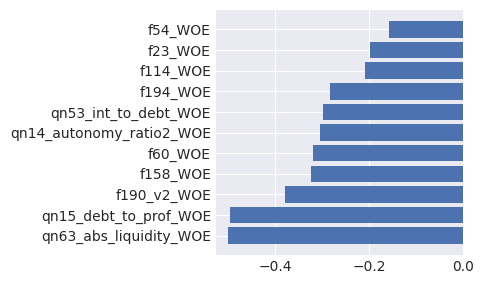

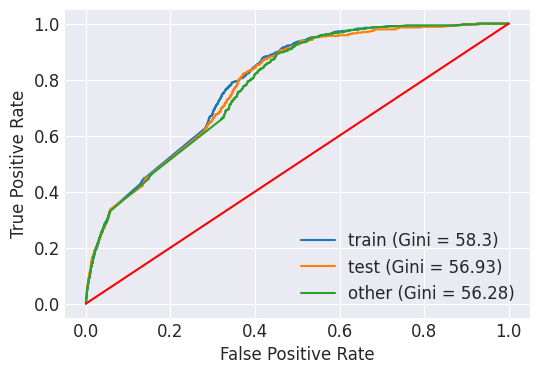

[INFO] [2023-04-28 10:27:10] 
      train   test  other  Bootstrap mean  Bootstrap std
Gini   58.3  56.93  56.28            56.7           0.64


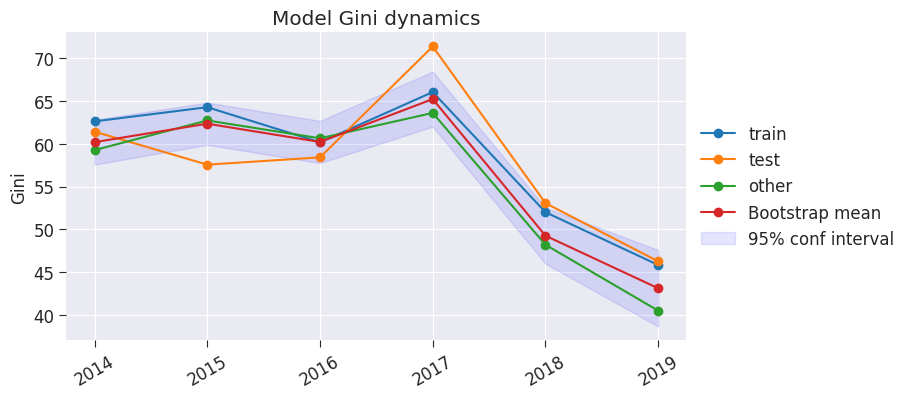

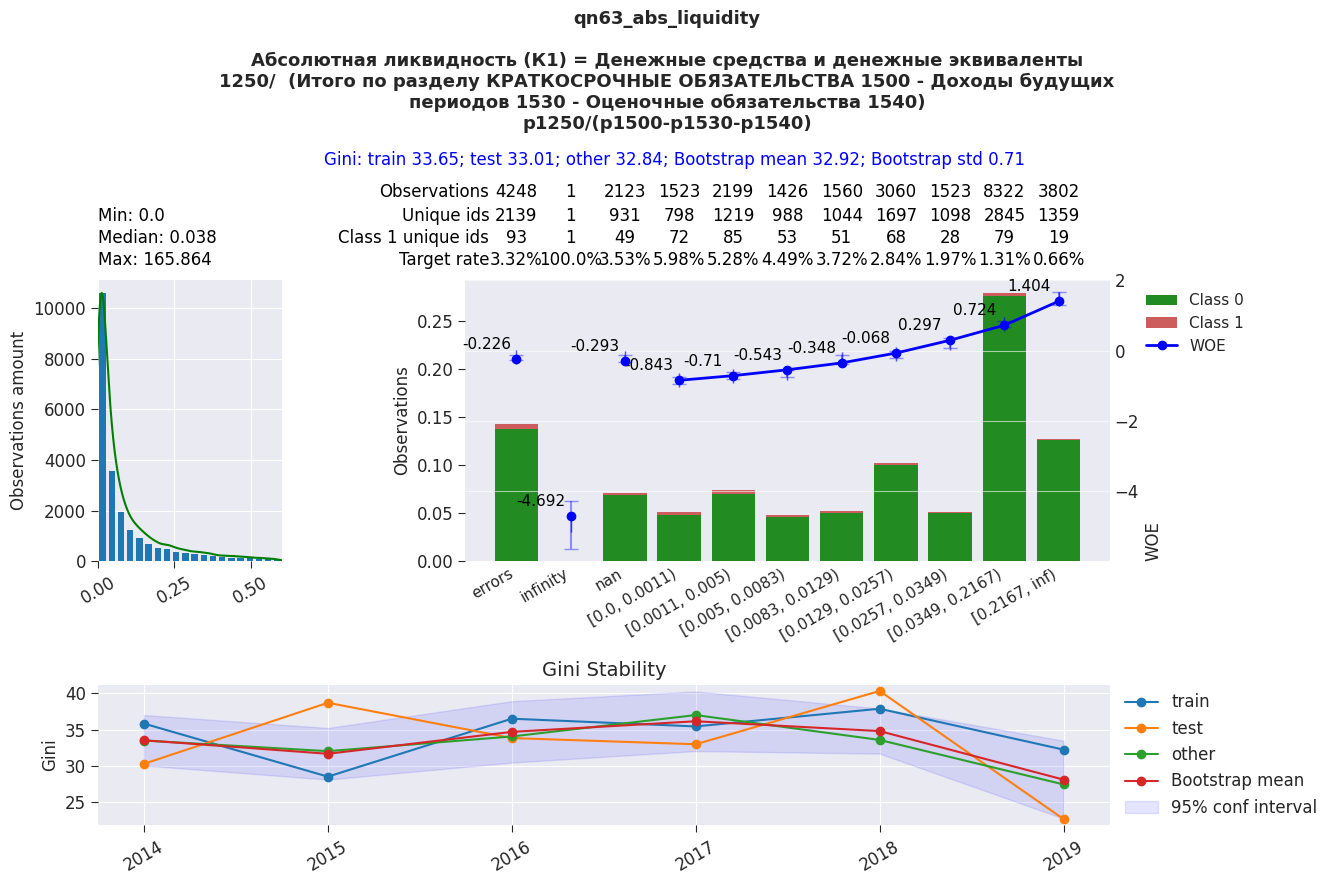

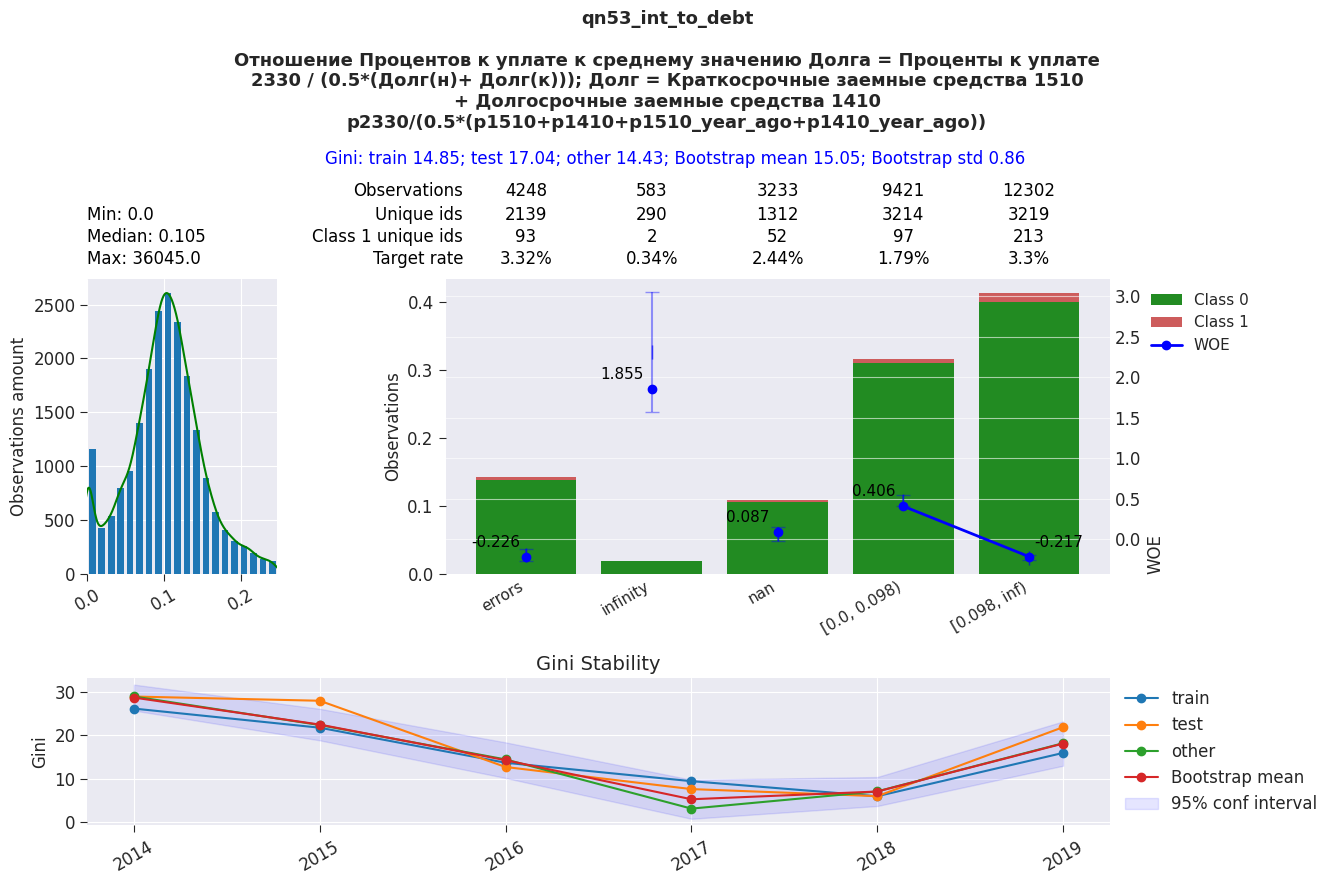

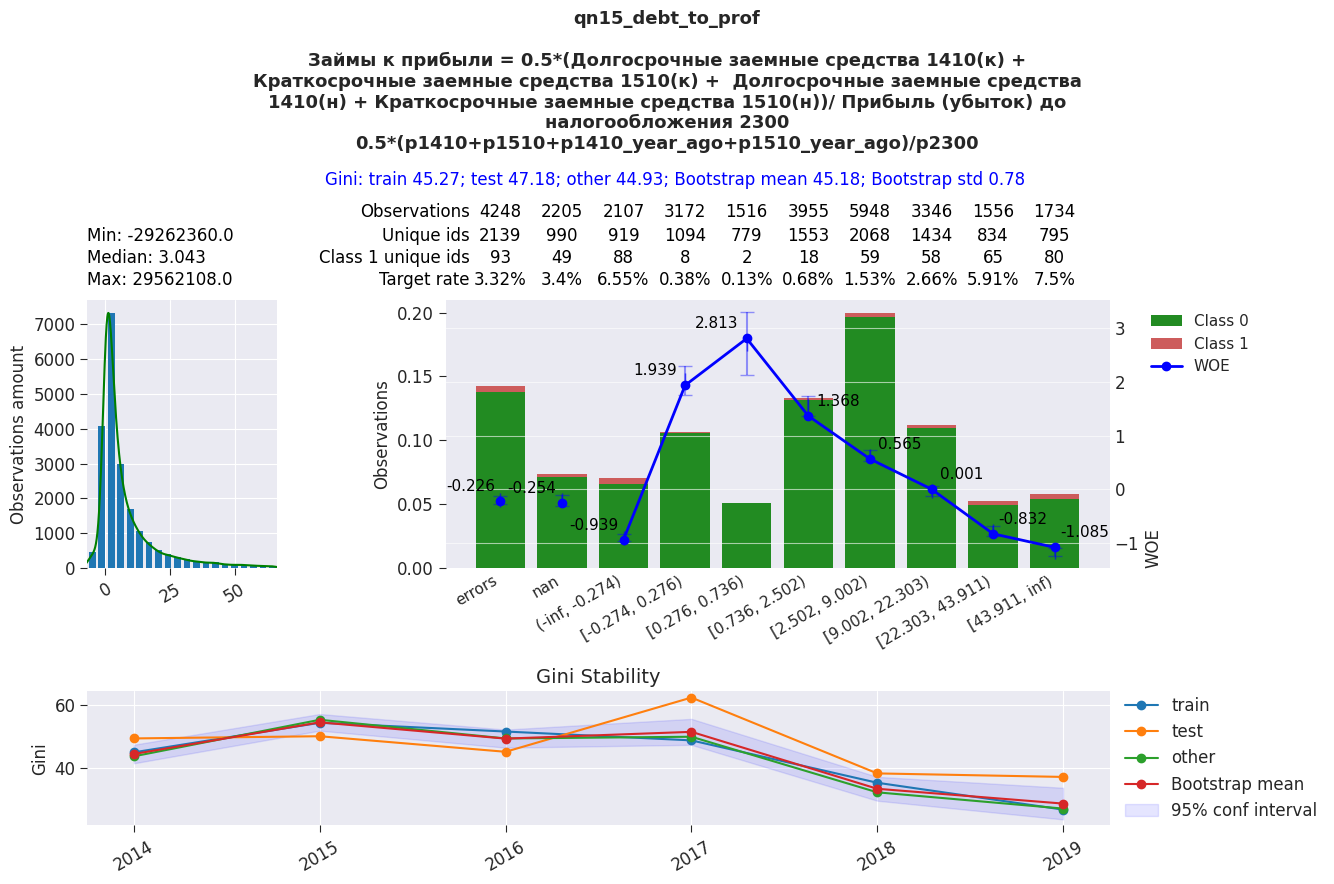

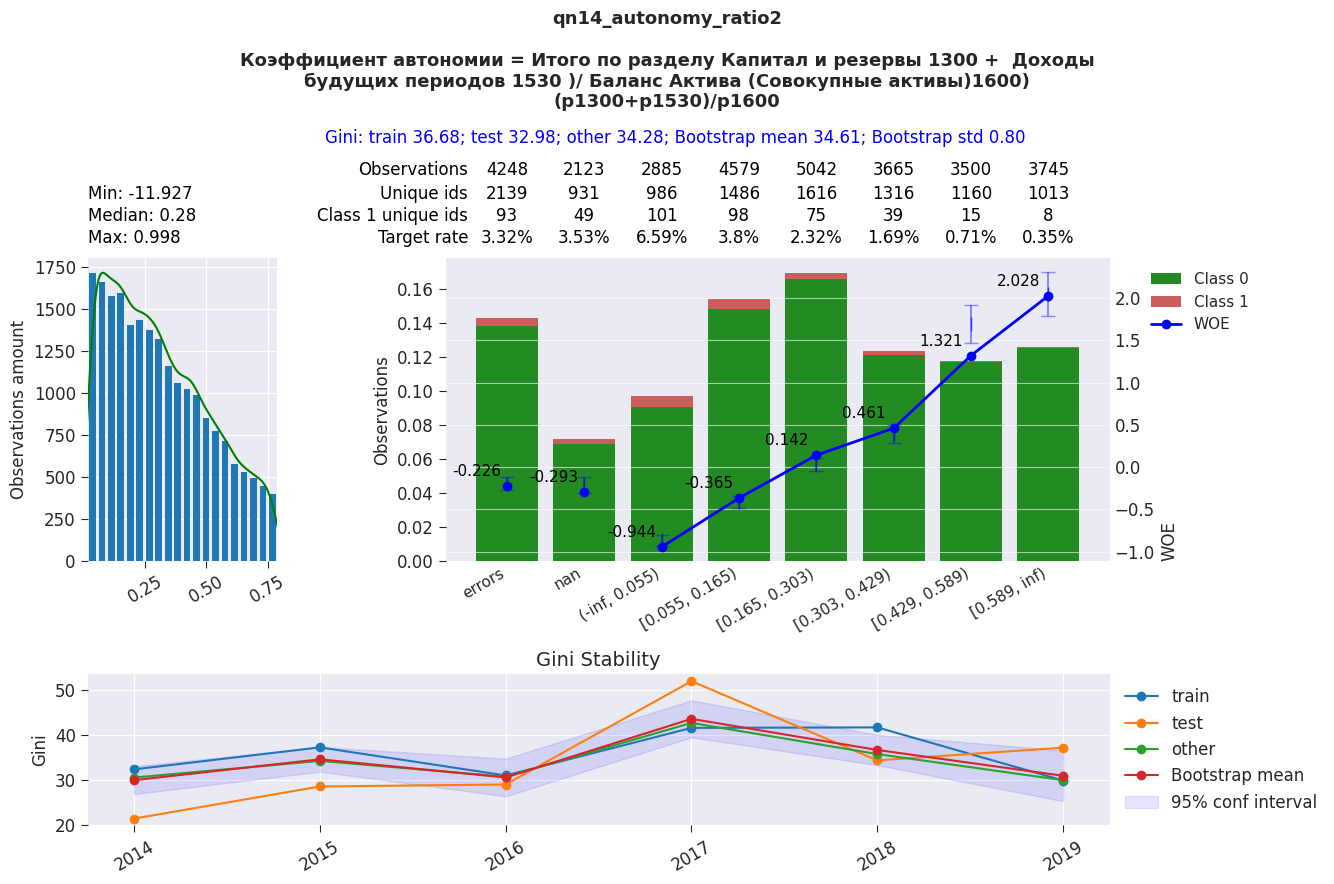

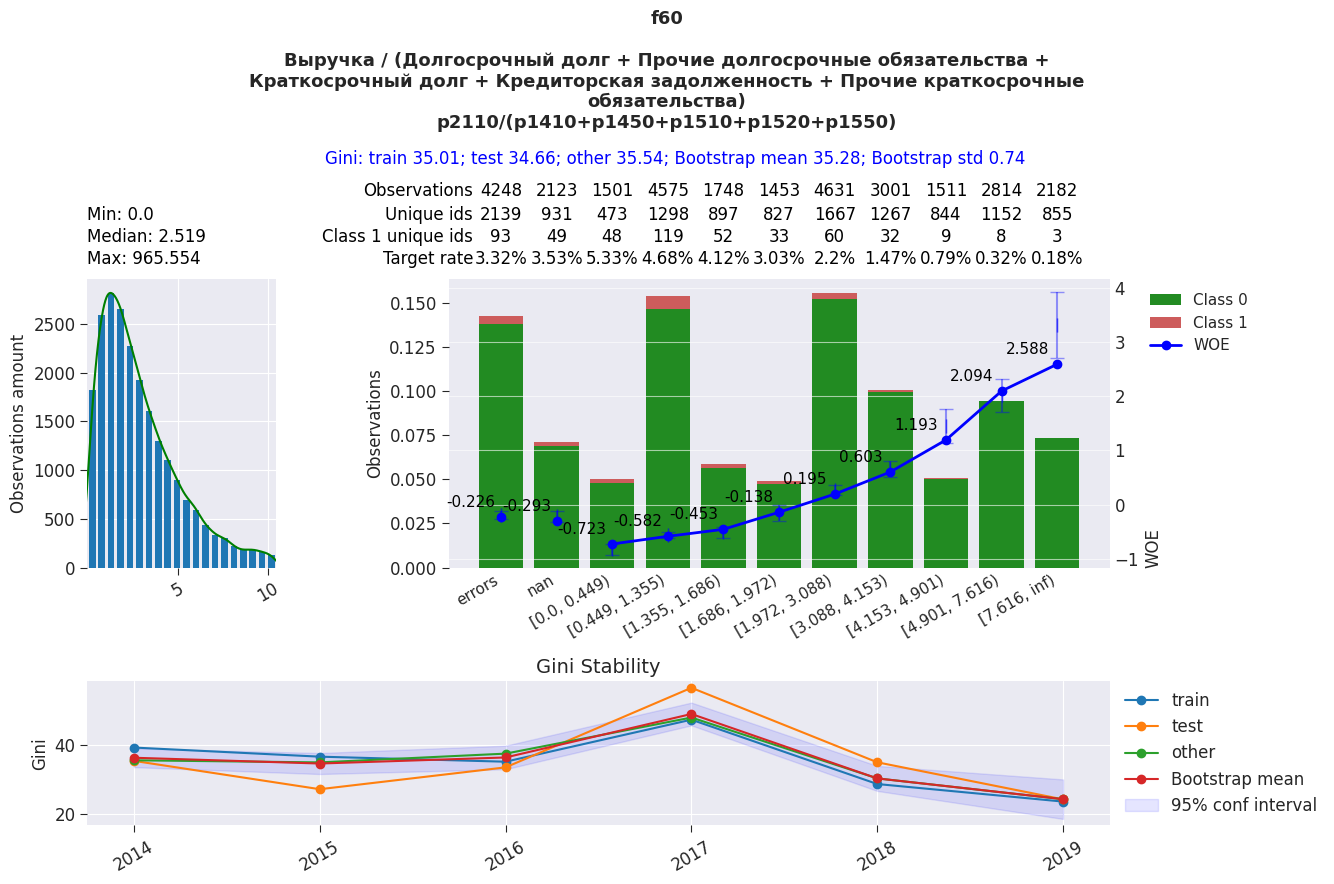

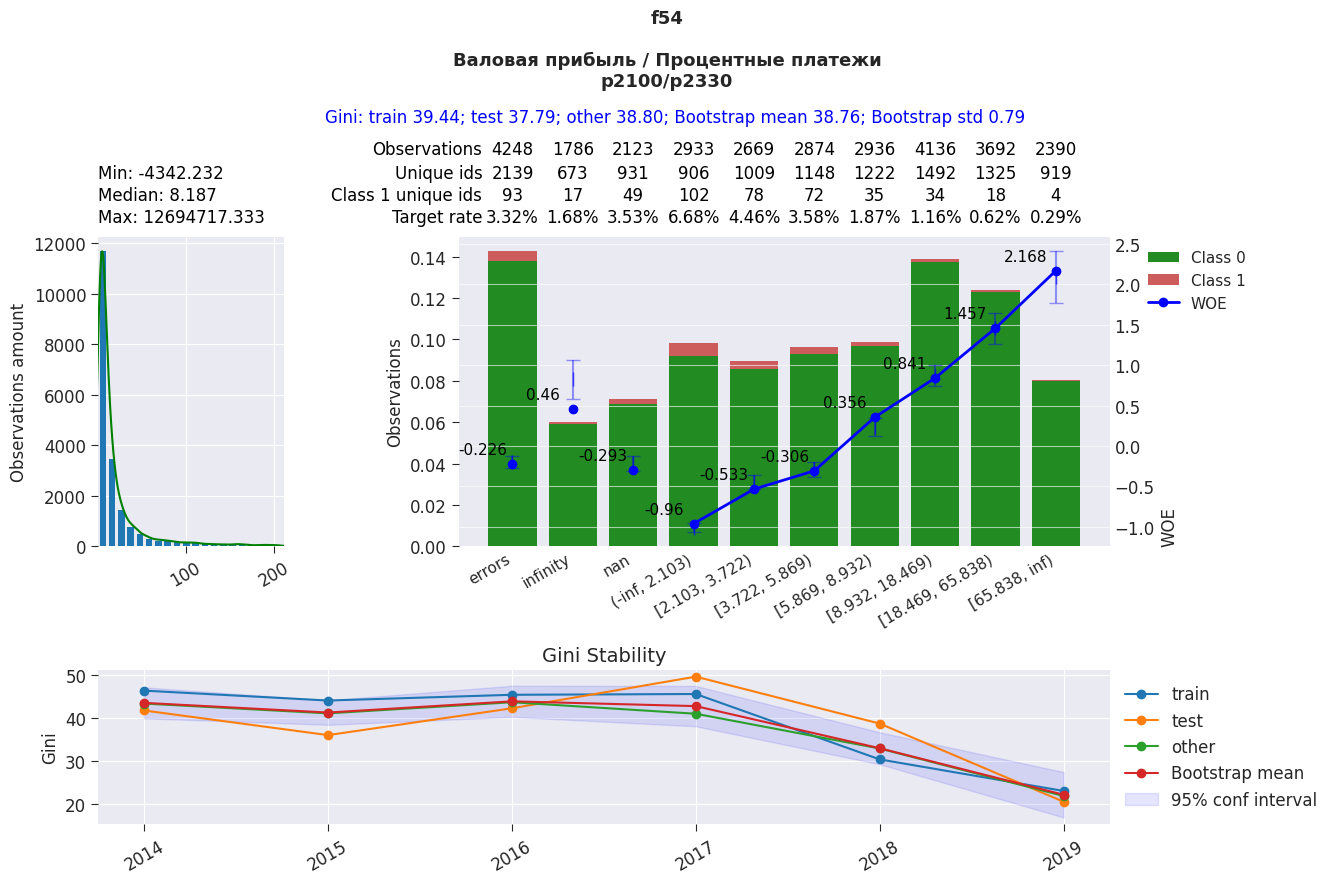

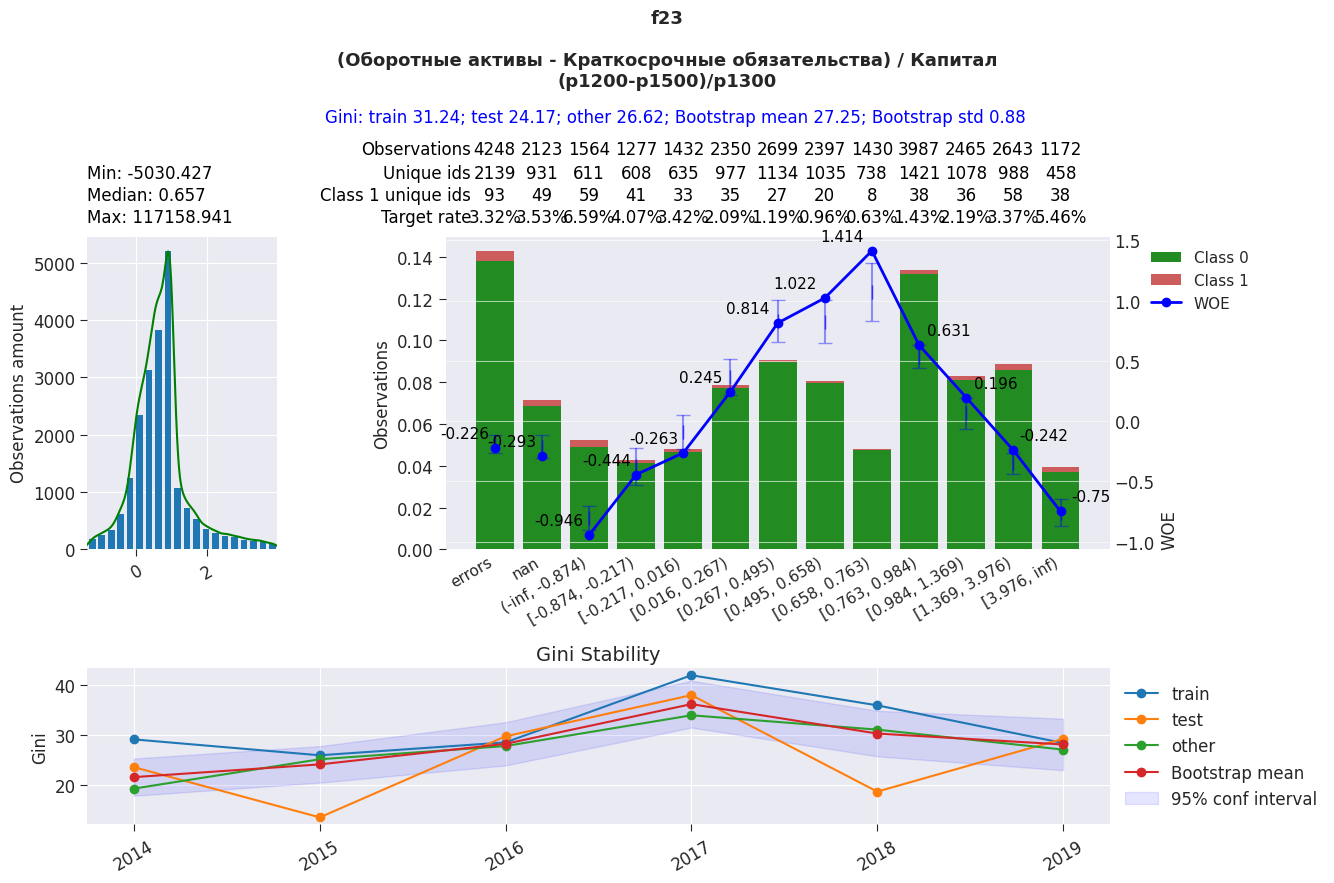

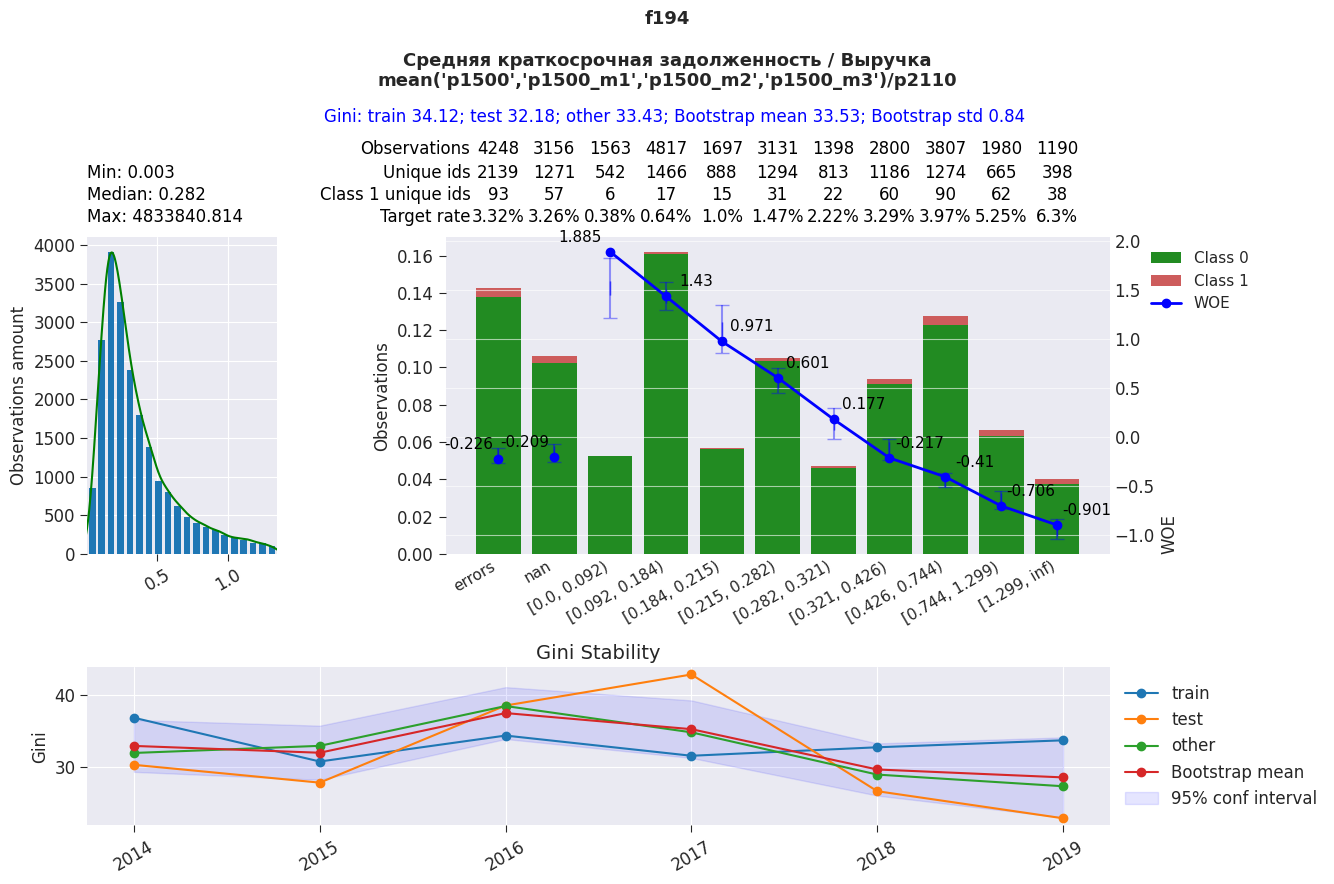

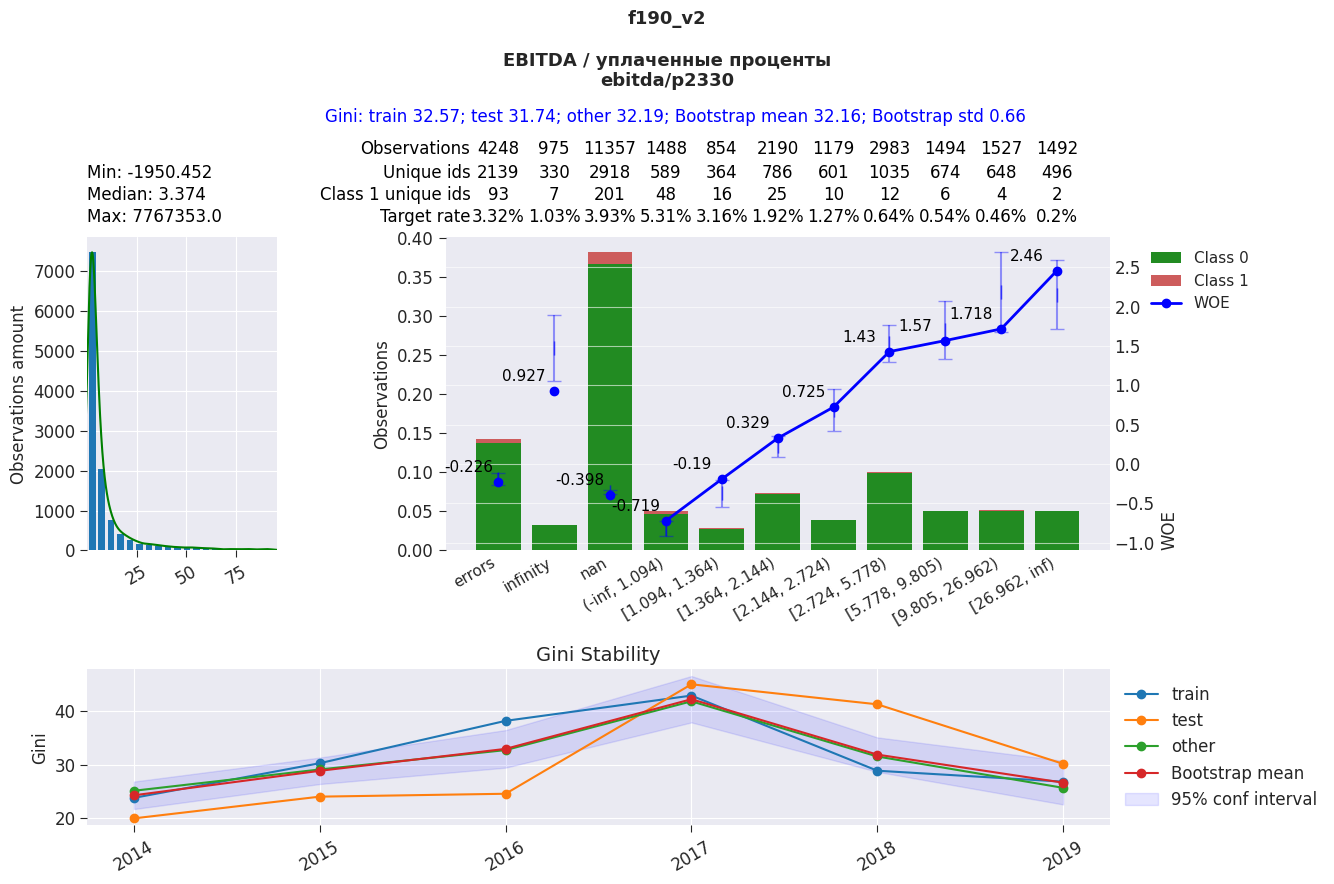

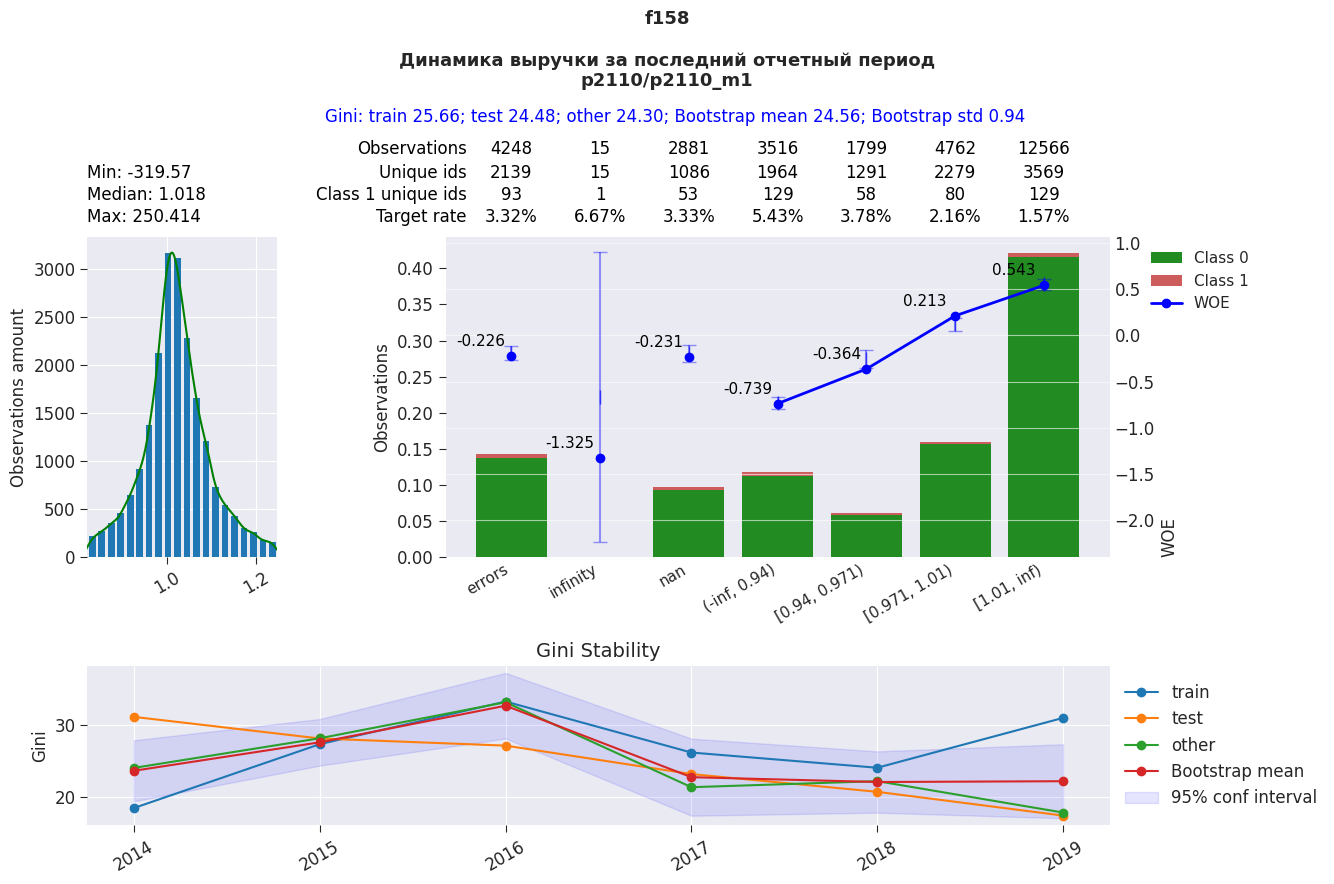

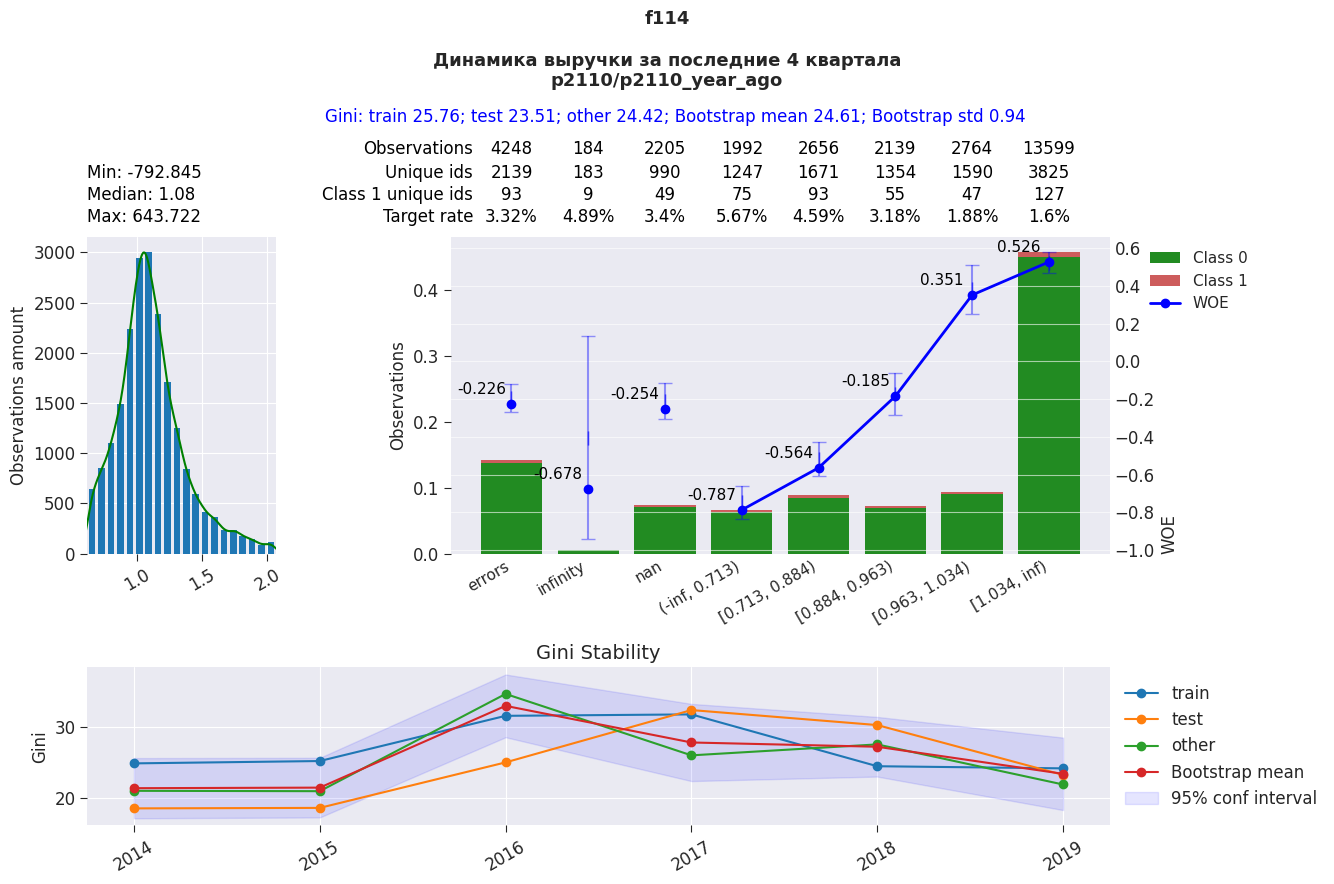

In [9]:
logreg.mfa(ds_t,                                 # ДатаСэмпл. В случае, если он не содержит трансформированные переменные, то выполняется трансформация трансформером self.transformer. При None берется self.ds
           features=None,                        # исходный список переменных для МФА. При None берутся все переменные, по которым есть активный биннинг
           hold=None,                            # список переменных, которые обязательно должны войти в модель
           features_ini=None,                    # список переменных, с которых стартует процедура отбора. Они могут быть исключены в процессе отбора
           limit_to_add=100,                     # максимальное кол-во переменных, которые могут быть добавлены к модели
           gini_threshold=10,                    # граница по джини для этапа 1
           corr_method='pearson',                # метод расчета корреляций для этапа 2. Доступны варианты 'pearson', 'kendall', 'spearman'
           corr_threshold=0.75,                  # граница по коэффициенту корреляции для этапа 2
           drop_with_most_correlations=False,    # вариант исключения факторов в корреляционном анализе для этапа 2
           drop_corr_iteratively=False,          # исключение коррелирующих факторов не на отдельном этапе 2, а итеративно в процессе этапа 3
                                                 #    (список кандидатов на добавление в модель формируется динамически после каждого шага,
                                                 #    из него исключаются все коррелирующие с уже включенными факторы).
                                                 #    Применимо только для типов отбора forward и stepwise
           selection_type='stepwise',            # тип отбора для этапа 3
           pvalue_threshold=0.05,                # граница по p-value для этапа 3
           pvalue_priority=True,                 # вариант определения лучшего фактора для этапа 3
           scoring='gini',                       # максимизируемая метрика для этапа 3
                                                 #     Варианты значений: 'gini', 'AIC', 'BIC' + все метрики доступные для вычисления через sklearn.model_selection.cross_val_score.
                                                 #     Все информационные метрики после вычисления умножаются на -1 для сохранения логики максимизации скора.
           score_delta=0.1,                      # минимальный прирост метрики для этапа 3
           n_stops=1,                            # количество срабатываний нарушений правил отбора по приросту метрики/p-value до завершения этапа 3
           cv=None,                              # параметр cv для вычисления скора sklearn.model_selection.cross_val_score для этапа 3. 
                                                 #     При None берется StratifiedKFold(5, shuffle=True, random_state=self.random_state)
           drop_positive_coefs=True,             # флаг для выполнения этапа 4
           
           # --- Кросс переменные ---
           crosses_simple=True,                  # True  - после трансформации кросс-переменные учавствут в отборе наравне со всеми переменными
                                                 # False - сначала выполняется отбор только на основных переменных,
                                                 #     затем в модель добавляются по тем же правилам кросс переменные, но не более, чем crosses_max_num штук
           crosses_max_num=10,                   # максимальное кол-во кросс переменных в модели. учитывается только при crosses_simple=False
           
           # --- Отчет ---
           verbose=True,                         # флаг для вывода подробных комментариев в процессе работы
           result_file='mfa.xlsx',               # файл, в который будут сохраняться результаты мфа
           metrics=None,                         # список метрик/тестов, результы расчета которых должны быть включены в отчет.
                                                 #     Элементы списка могут иметь значения (не чувствительно к регистру):
                                                 #         'ontime': расчет динамики джини по срезам,
                                                 #         'vif'   : расчет Variance Inflation Factor,
                                                 #         'psi'   : расчет Population Population Stability Index,
                                                 #         'wald'  : тест Вальда,
                                                 #         'ks'    : тест Колмогорова-Смирнова,
                                                 #         func    : пользовательская функция, которая принимает целевую и зависимую переменную,
                                                 #                   и возвращает числовое значение метрики
                                                 #                   Например,
                                                 #                   def custom_metric(y_true, y_pred):
                                                 #                       from sklearn.metrics import roc_curve, f1_score
                                                 #                       fpr, tpr, thresholds = roc_curve(y_true, y_pred)
                                                 #                       thres = thresholds[np.argmax(tpr * (1 - fpr))]
                                                 #                       return f1_score(y_true, (y_pred > thres).astype(int))
                                                 #                   metrics = ['vif', 'ks', 'psi', custom_metric]
           metrics_cv=None                       # список метрик, рассчитываемых через sklearn.model_selection.cross_val_score.
                                                 #     Аналогично параметру metrics элементами могут быть строки, поддерживаемые cross_val_score, либо пользовательские функции
                                                 #     Например, ['roc_auc', 'neg_log_loss', 'gini', 'f1', 'accuracy', custom_metric]
          )

### 5.4. Сохранение модели

In [10]:
logreg.save_model(file_name=f'{result_folder}/model.json', # название json файла для сохранения модели
                  pickle_protocol=4                        # версия протокола для сериализации объектов. Версия 5 доступна только для питона 3.8+
                 )  

[INFO] [2023-04-28 10:30:24] The model was successfully saved to file FO_output/model.json


## 6. Загрузка сохраненной модели для дальнейшей работы с ней

In [11]:
logreg = LogisticRegressionModel(ds=ds)
logreg.load_model(file_name=f'{result_folder}/model.json')

[INFO] [2023-04-28 10:30:24] Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
[INFO] [2023-04-28 10:30:24] The model was loaded from file FO_output/model.json
[INFO] [2023-04-28 10:30:24] clf = SGDClassifier(alpha=0.001, loss='log', random_state=0)
[INFO] [2023-04-28 10:30:24] name = FO
[INFO] [2023-04-28 10:30:24] coefs = {'qn63_abs_liquidity_WOE': -0.501, 'qn53_int_to_debt_WOE': -0.298, 'qn15_debt_to_prof_WOE': -0.497, 'qn14_autonomy_ratio2_WOE': -0.304, 'f60_WOE': -0.32, 'f54_WOE': -0.157, 'f23_WOE': -0.197, 'f194_WOE': -0.283, 'f190_v2_WOE': -0.378, 'f158_WOE': -0.324, 'f114_WOE': -0.209}
[INFO] [2023-04-28 10:30:24] intercept = -3.684
[INFO] [2023-04-28 10:30:24] calibration = None
[INFO] [2023-04-28 10:30:24] scale = None
[INFO] [2023-04-28 10:30:24] round_digits = 3


## 7. Калибировка
### 7.1. Вычисление ЦТ

In [12]:
CT = df.groupby('report_date')['default1y'].mean().mean()
CT

0.028426774710298034

### 7.2. Калибровка скора модели линейной функцией score_calibr = a + b*score

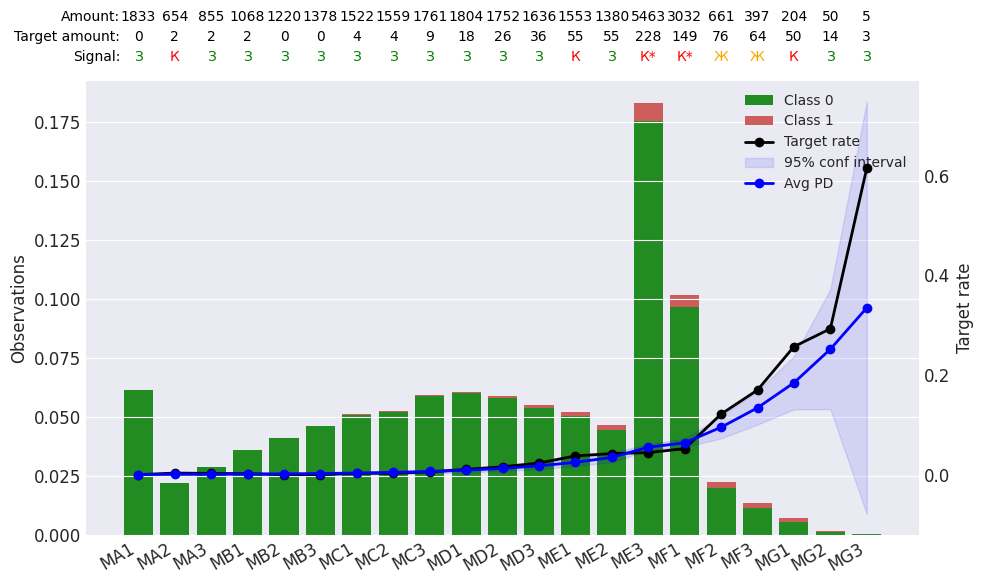

[0.28838, 1.06796]

In [13]:
logreg.calibrate(
                 CT,                             # значение центральной тенденции, к которому приводится среднее PD модели
                 method=0,                       # метод калибровки. Доступны два варианта:
                                                 #    0 - Строится логрег скора на таргет, коэффициент b приравнивается полученному коэффициенту при скоре,
                                                 #      коэффицент a затем подбирается солвером для попадания в ЦТ при фиксированном b
                                                 #    1 - Расчитываются веса наблюдений и строится логрег скора на таргет с весами, a и b приравниваются коэффициентам логрега
                                                 #    2 - Коэффициенты рассчитываются минимизацией заданной функции через вызов scipy.optimize.minimize(fun=fun, x0=x0, args=args, method='nelder-mead')
                                                 #    любое другое значение - перерасчет коэффициентов не происходит, проводится тест на коэффициентах из self.calibration
                 sample_name=None,               # название сэмпла, на котором проводится калибровка
                 scale=None,                     # шкала, на которой будет проведен биноминальный тест. Задается в виде словаря {грейд: верхняя граница PD грейда}. По умолчанию берется мастер-шкала
                 score_field=None,               # поле со скором. Если оно отсутвует в ДатаСэмпле, то будет вызван метод self.scoring
                 result_file='calibration.xlsx', # название эксель файла, в который будут записаны результаты
                 plot_flag=True,                 # флаг для вывода графика
                 
                 # --- Метод калибровки 2 ---
                 fun=None,                       # пользовательская функция
                 x0=None,                        # начальные значения параметров
                 args=None,                      # кортеж аргументов
                 lambda_ab=None                  # функция для формирования списка [a, b] из результирующих параметров солвера. При None берется lambda x: x
                 
                                                 #   Примеры использования для калибровки с ограничением минимального PD модели значением minPD:
                                                 #   Вариант 1) Минимизация функции двух переменных
                                                 #         def CT_minPD_delta(params, score, CT, minPD):
                                                 #             a, b = params
                                                 #             pd = 1 / (1 + np.exp(-(a + score * b)))
                                                 #             return (CT - pd.mean()) ** 2 + 10 * (minPD - pd.min())**2
 
                                                 #         fun=CT_minPD_delta, x0=[0, 1], args=(ds.samples[ds.train_name]['score'], CT, minPD), lambda_ab=None
 
                                                 #    Вариант 2) Минимизация функции одной переменной, вычисление коэффициента b через связь minPD и лучшего скора по выборке
                                                 #         def CT_delta(params, score, CT, minPD, best_score):
                                                 #             a = params
                                                 #             b = (-log(1 / minPD - 1) - a) / best_score
                                                 #             pd = 1 / (1 + np.exp(-(a + score * b)))
                                                 #             return (CT - pd.mean()) ** 2
 
                                                 #         best_score = ds.samples[ds.train_name]['score'].min()
                                                 #         fun=CT_delta, x0=0, args=(ds.samples[ds.train_name]['score'], CT, minPD, best_score), lambda_ab=lambda x: (x[0], (-log(1 / minPD - 1) - x[0]) / best_score))
                )

### 7.3. Сохранение откалиброванной модели

In [14]:
logreg.save_model(file_name=f'{result_folder}/model_calibr.json')

[INFO] [2023-04-28 10:30:27] The model was successfully saved to file FO_output/model_calibr.json


## 8. Валидация
### 8.1. Валидационные тесты библиотекой bankmetrics от УМРВ

In [15]:
logreg.validate(ds,                              # ДатаСэмпл
                result_file='validation.xlsx',   # результирующий эксель файл
                score_field='score',             # поле со расчитанным скор (при отсутcnвии этого поля в выборке будет вызван метод self.scoring)
                pd_field='pd',                   # поле с расчитанным PD
                scale_field='scale'              # поле с расчитанным грейдом
               ) 

[INFO] [2023-04-28 10:30:27] --------------------------------------------------------------------- Validation ---------------------------------------------------------------------
IV...
Тест Колмогорова-Смирнова...
Джини...
Калибровка...
Корреляция...
VIF...
WOE...
Бин тест...
Хосмер-Лемешев...
Херфиндаль...
Gini_model...
Индекс PSI test-train...
[INFO] [2023-04-28 10:30:37] Results of validation tests was saved to file FO_output/validation.xlsx


## 9. Применение модели
### 9.1. С использованием библиотеки vtb_scorekit

In [16]:
logreg = LogisticRegressionModel()
logreg.load_model(file_name=f'{result_folder}/model_calibr.json')
logreg.scoring(df,                               # ДатаСэмпл или ДатаФрейм. Возвращается объект того же типа
               score_field='score',              # поле, в которое должен быть записан посчитанный скор
               pd_field='prob',                  # поле, в которое должен быть записан посчитанный PD
               scale_field='scale'               # поле, в которое должен быть записан посчитанный грейд
              ) 

Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
The model was loaded from file FO_output/model_calibr.json
clf = SGDClassifier(alpha=0.001, loss='log', random_state=0)
name = FO
coefs = {'qn63_abs_liquidity_WOE': -0.501, 'qn53_int_to_debt_WOE': -0.298, 'qn15_debt_to_prof_WOE': -0.497, 'qn14_autonomy_ratio2_WOE': -0.304, 'f60_WOE': -0.32, 'f54_WOE': -0.157, 'f23_WOE': -0.197, 'f194_WOE': -0.283, 'f190_v2_WOE': -0.378, 'f158_WOE': -0.324, 'f114_WOE': -0.209}
intercept = -3.684
calibration = [0.28838, 1.06796]
scale = {'MA1': 0.0005, 'MA2': 0.000695, 'MA3': 0.000976, 'MB1': 0.001372, 'MB2': 0.001927, 'MB3': 0.002708, 'MC1': 0.003804, 'MC2': 0.005344, 'MC3': 0.007508, 'MD1': 0.010549, 'MD2': 0.014821, 'MD3': 0.020822, 'ME1': 0.029254, 'ME2': 0.041101, 'ME3': 0.057744, 'MF1': 0.081128, 'MF2': 0.11398, 'MF3': 0.160137, 'MG1': 0.224984, 'MG2': 0.31609, 'MG3': 1}
round_digits = 3


inn report_date sample_type_fo  default1y  fo_hit  any_fo_hit  \
0       7723627614  2019-02-01     test.other        0.0       1           1   
1       7116019123  2016-09-01    train.other        0.0       1           1   
2       2801133630  2016-10-01          train        0.0       0           1   
3       9710003010  2017-08-01    train.other        0.0       1           1   
4       7814124664  2017-11-01    train.other        0.0       1           1   
...            ...         ...            ...        ...     ...         ...   
163495  3018312912  2016-02-01     test.other        0.0       1           1   
163496  7722292274  2016-07-01     test.other        0.0       1           1   
163497  6659122795  2014-12-01     test.other        0.0       0           0   
163498  4334003671  2017-08-01    train.other        0.0       1           1   
163499  7813109127  2016-10-01          train        0.0       1           1   

               f2         f3         f5         f6  ...  \
0       5.131e-01  8.193e-01  7.955e+01  8.109e-01  ...   
1       2.608e-01  3.965e-01  1.456e+00  3.117e-01  ...   
2       1.000e+10  1.000e+10  1.000e+10  1.000e+10  ...   
3       2.723e-01  1.000e+09  3.308e-01  3.308e-01  ...   
4       4.876e-01  3.178e+01  3.778e+00  3.377e+00  ...   
...           ...        ...        ...        ...  ...   
163495  7.704e-01  1.000e+09  1.000e+09  1.000e+09  ...   
163496  4.195e-02  4.841e-02  3.548e-01  4.260e-02  ...   
163497        NaN        NaN        NaN        NaN  ...   
163498  5.660e+00  1.000e+09  1.000e+09  1.000e+09  ...   
163499  9.180e-01  4.437e+00  2.407e+01  3.747e+00  ...   

        qn14_autonomy_ratio2_WOE  qn53_int_to_debt_WOE  f114_WOE  f23_WOE  \
0                          0.461                -0.217     0.526   -0.242   
1                          0.142                -0.217     0.526   -0.242   
2                         -0.226                -0.226    -0.226   -0.226   
3                          0.142                 0.406     0.526    0.631   
4                          0.461                -0.217     0.526    0.631   
...                          ...                   ...       ...      ...   
163495                     1.321                 0.406     0.526    1.022   
163496                    -0.944                 0.406    -0.185   -0.750   
163497                    -0.293                 0.087    -0.254   -0.293   
163498                     2.028                 0.087     0.526    1.414   
163499                     1.321                 0.406     0.526    0.631   

        score   prob  scale  score_calibr  prob_calibr  scale_calibr  
0      -5.491  0.004    MC2        -5.576    3.775e-03           MC1  
1      -3.754  0.023    ME1        -3.721    2.365e-02           ME1  
2      -2.900  0.052    ME3        -2.809    5.684e-02           ME3  
3      -6.347  0.002    MB2        -6.490    1.516e-03           MB2  
4      -6.570  0.001    MB2        -6.728    1.196e-03           MB1  
...       ...    ...    ...           ...          ...           ...  
163495 -6.868  0.001    MB1        -7.046    8.702e-04           MA3  
163496 -2.057  0.113    MF2        -1.909    1.291e-01           MF3  
163497 -2.813  0.057    ME3        -2.716    6.206e-02           MF1  
163498 -6.478  0.002    MB2        -6.629    1.319e-03           MB1  
163499 -6.075  0.002    MB3        -6.199    2.027e-03           MB3  

[163500 rows x 266 columns]

### 9.2. Генерация хардкода для использования модели без сторонних библиотек

In [17]:
logreg.to_py(file_name=f'{result_folder}/FO_model.py',     # название питоновского файла, куда должен быть сохранен код
             score_field='score',                          # поле, в которое должен быть записан посчитанный скор
             pd_field='pd',                                # поле, в которое должен быть записан посчитанный PD
             scale_field='scale'                           # поле, в которое должен быть записан посчитанный грейд
            )

The model code for implementation saved to file FO_output/FO_model.py
import pandas as pd
import numpy as np


def to_scale(PD):
    scale = {'MA1': 0.0005, 'MA2': 0.000695, 'MA3': 0.000976, 'MB1': 0.001372, 'MB2': 0.001927, 'MB3': 0.002708, 'MC1': 0.003804, 'MC2': 0.005344, 'MC3': 0.007508, 'MD1': 0.010549, 'MD2': 0.014821, 'MD3': 0.020822, 'ME1': 0.029254, 'ME2': 0.041101, 'ME3': 0.057744, 'MF1': 0.081128, 'MF2': 0.11398, 'MF3': 0.160137, 'MG1': 0.224984, 'MG2': 0.31609, 'MG3': 1}
    for s in scale:
        if PD < scale[s]:
            return s
    return 'MSD'


def scoring(df, score_field='score', pd_field='pd', scale_field=None):
    """
    Функция скоринга выборки
    Arguments:
        df: [pd.DataFrame] входной ДатаФрейм, должен содержать все нетрансформированные переменные модели
        score_field: [str] поле, в которое должен быть записан посчитанный скор
        pd_field: [str] поле, в которое должен быть записан посчитанный PD
        scale_field: [str] поле, в которое